<a href="https://colab.research.google.com/github/CarsonSwa1/491CV-SuperResolution/blob/main/comp_vis_first_arc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import listdir
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#some hyperparameters
epochs = 2000
batch_size = 4
learning_rate = 0.00003

In [ ]:
FIXED_0 = 1250
FIXED_1 = 2040

SHAPE_IN = (3,156,255)
SHAPE_OUT = (3,312,510)

#Formating Data
training_data = []
for i, each in tqdm(enumerate(listdir("DIV2K_train_HR")),total = 800):
    img = cv2.imread(f'DIV2K_train_HR/{each}')
    if img.shape[0] == FIXED_1:
      img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    if img.shape[0] >= FIXED_0:
      #crop to a uniform size
      img = img[:FIXED_0,:,:]

      #get different size images
      img_x4 = cv2.resize(img, dsize = None, fx = .25, fy = .25, interpolation = cv2.INTER_CUBIC)
      img_x8 = cv2.resize(img_x4, dsize = None, fx = .5, fy = .5, interpolation = cv2.INTER_CUBIC)

      #gets difference image
      img_add = img_x4 - cv2.resize(img_x8, dsize = None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)

      #convert to Tensor
      tensor_img_x8 = torch.from_numpy(img_x8)
      tensor_out = torch.from_numpy(img_add)
      tensor_lab = torch.from_numpy(img_x4)

      #convert to FloatTensor
      tensor_img_x8 = tensor_img_x8.type(torch.FloatTensor)
      tensor_out = tensor_out.type(torch.FloatTensor)
      tensor_lab = tensor_lab.type(torch.FloatTensor)

      #reshape
      tensor_img_x8 = torch.reshape(tensor_img_x8,SHAPE_IN)
      tensor_out = torch.reshape(tensor_out,SHAPE_OUT)
      tensor_lab = torch.reshape(tensor_lab,SHAPE_OUT)
      training_data.append((tensor_img_x8, tensor_out))

NameError: name 'tqdm' is not defined

In [ ]:
#Create data loader
train_loader = torch.utils.data.DataLoader(training_data[:100],batch_size=batch_size,shuffle=True)
train_loader2 = torch.utils.data.DataLoader(training_data[:100],batch_size=1,shuffle=False)

In [ ]:
# convolutional neural network
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    # channels, output, kernel_size
    self.conv1 = nn.Conv2d(3, 6, 3, bias = False)
    ###
    self.conv2 = nn.Conv2d(6,18,5, bias = False)
    ###
    self.conv3 = nn.Conv2d(18,27,3,  bias = False)
    ###
    #shuffle pixels
    self.pixel_shuffle = nn.PixelShuffle(3)
    #pool to output size
    self.fractionalPool = nn.FractionalMaxPool2d(kernel_size = 5,output_size = (312,510))
    #normalizer
    self.batchnorm2 = nn.BatchNorm2d(27)
    self.batchnorm1 = nn.BatchNorm2d(6)

  def forward(self, x):
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = self.batchnorm2(x)
    x = self.pixel_shuffle(x)
    x = self.fractionalPool(x)
    return x


In [ ]:
#Initialize Model
model = ConvNet().to(device)

#loss_function = torch.nn.CrossEntropyLoss()
loss_function = torch.nn.MSELoss()

#optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#UNCOMMENT TO LOAD PAST MODEL
#model = ConvNet().to(device)
#model.load_state_dict(torch.load('comp_vis_model2'))

<All keys matched successfully>

In [ ]:
for epoch in tqdm(range(epochs)):
  avg = 0
  for i, (images, labels) in enumerate(train_loader):

    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = loss_function(outputs, labels)

    avg += int(loss.data)

    #backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('AVG: ', avg/25)

torch.save(model.state_dict(),'comp_vis_model')


  0%|          | 1/1000 [00:00<05:12,  3.19it/s]

AVG:  24644.68


  0%|          | 2/1000 [00:00<04:29,  3.71it/s]

AVG:  24642.28


  0%|          | 3/1000 [00:00<04:14,  3.92it/s]

AVG:  24642.76


  0%|          | 4/1000 [00:01<04:07,  4.03it/s]

AVG:  24642.08


  0%|          | 5/1000 [00:01<04:04,  4.07it/s]

AVG:  24636.92


  1%|          | 6/1000 [00:01<04:02,  4.10it/s]

AVG:  24641.52


  1%|          | 7/1000 [00:01<04:00,  4.14it/s]

AVG:  24639.92


  1%|          | 8/1000 [00:01<03:58,  4.15it/s]

AVG:  24637.96


  1%|          | 9/1000 [00:02<03:58,  4.16it/s]

AVG:  24637.88


  1%|          | 10/1000 [00:02<03:59,  4.14it/s]

AVG:  24636.24


  1%|          | 11/1000 [00:02<03:58,  4.15it/s]

AVG:  24636.64


  1%|          | 12/1000 [00:02<03:57,  4.16it/s]

AVG:  24634.68


  1%|▏         | 13/1000 [00:03<03:56,  4.17it/s]

AVG:  24633.56


  1%|▏         | 14/1000 [00:03<03:55,  4.18it/s]

AVG:  24629.96


  2%|▏         | 15/1000 [00:03<03:55,  4.19it/s]

AVG:  24631.36


  2%|▏         | 16/1000 [00:03<03:55,  4.19it/s]

AVG:  24630.0


  2%|▏         | 17/1000 [00:04<03:55,  4.18it/s]

AVG:  24629.48


  2%|▏         | 18/1000 [00:04<03:54,  4.19it/s]

AVG:  24627.48


  2%|▏         | 19/1000 [00:04<03:53,  4.20it/s]

AVG:  24632.04


  2%|▏         | 20/1000 [00:04<03:53,  4.19it/s]

AVG:  24627.48


  2%|▏         | 21/1000 [00:05<03:53,  4.19it/s]

AVG:  24624.96


  2%|▏         | 22/1000 [00:05<03:53,  4.19it/s]

AVG:  24628.2


  2%|▏         | 23/1000 [00:05<03:55,  4.15it/s]

AVG:  24624.64


  2%|▏         | 24/1000 [00:05<03:57,  4.11it/s]

AVG:  24622.76


  2%|▎         | 25/1000 [00:06<03:58,  4.08it/s]

AVG:  24622.2


  3%|▎         | 26/1000 [00:06<03:57,  4.10it/s]

AVG:  24622.92


  3%|▎         | 27/1000 [00:06<03:59,  4.07it/s]

AVG:  24622.68


  3%|▎         | 28/1000 [00:06<03:58,  4.08it/s]

AVG:  24620.16


  3%|▎         | 29/1000 [00:07<03:58,  4.07it/s]

AVG:  24620.68


  3%|▎         | 30/1000 [00:07<03:59,  4.05it/s]

AVG:  24620.68


  3%|▎         | 31/1000 [00:07<04:02,  4.00it/s]

AVG:  24618.76


  3%|▎         | 32/1000 [00:07<04:06,  3.93it/s]

AVG:  24615.8


  3%|▎         | 33/1000 [00:08<04:05,  3.93it/s]

AVG:  24615.08


  3%|▎         | 34/1000 [00:08<04:00,  4.01it/s]

AVG:  24612.2


  4%|▎         | 35/1000 [00:08<03:58,  4.05it/s]

AVG:  24614.32


  4%|▎         | 36/1000 [00:08<03:55,  4.09it/s]

AVG:  24614.76


  4%|▎         | 37/1000 [00:09<03:53,  4.12it/s]

AVG:  24616.32


  4%|▍         | 38/1000 [00:09<03:52,  4.14it/s]

AVG:  24610.28


  4%|▍         | 39/1000 [00:09<03:52,  4.13it/s]

AVG:  24611.64


  4%|▍         | 40/1000 [00:09<03:51,  4.14it/s]

AVG:  24608.84


  4%|▍         | 41/1000 [00:10<03:51,  4.15it/s]

AVG:  24607.68


  4%|▍         | 42/1000 [00:10<03:52,  4.13it/s]

AVG:  24608.24


  4%|▍         | 43/1000 [00:10<03:51,  4.13it/s]

AVG:  24606.76


  4%|▍         | 44/1000 [00:10<03:51,  4.14it/s]

AVG:  24606.44


  4%|▍         | 45/1000 [00:10<03:49,  4.16it/s]

AVG:  24606.4


  5%|▍         | 46/1000 [00:11<03:48,  4.17it/s]

AVG:  24603.48


  5%|▍         | 47/1000 [00:11<03:48,  4.17it/s]

AVG:  24603.52


  5%|▍         | 48/1000 [00:11<03:48,  4.17it/s]

AVG:  24603.12


  5%|▍         | 49/1000 [00:11<03:47,  4.18it/s]

AVG:  24602.52


  5%|▌         | 50/1000 [00:12<03:46,  4.19it/s]

AVG:  24599.92


  5%|▌         | 51/1000 [00:12<03:46,  4.19it/s]

AVG:  24599.08


  5%|▌         | 52/1000 [00:12<03:47,  4.17it/s]

AVG:  24599.16


  5%|▌         | 53/1000 [00:12<03:47,  4.17it/s]

AVG:  24599.0


  5%|▌         | 54/1000 [00:13<03:46,  4.18it/s]

AVG:  24596.6


  6%|▌         | 55/1000 [00:13<03:45,  4.18it/s]

AVG:  24598.12


  6%|▌         | 56/1000 [00:13<03:45,  4.18it/s]

AVG:  24595.44


  6%|▌         | 57/1000 [00:13<03:45,  4.18it/s]

AVG:  24593.44


  6%|▌         | 58/1000 [00:14<03:45,  4.18it/s]

AVG:  24593.12


  6%|▌         | 59/1000 [00:14<03:44,  4.19it/s]

AVG:  24594.32


  6%|▌         | 60/1000 [00:14<03:44,  4.18it/s]

AVG:  24593.4


  6%|▌         | 61/1000 [00:14<03:46,  4.15it/s]

AVG:  24589.6


  6%|▌         | 62/1000 [00:15<03:46,  4.15it/s]

AVG:  24590.52


  6%|▋         | 63/1000 [00:15<03:45,  4.16it/s]

AVG:  24593.0


  6%|▋         | 64/1000 [00:15<03:44,  4.16it/s]

AVG:  24588.52


  6%|▋         | 65/1000 [00:15<03:45,  4.15it/s]

AVG:  24590.36


  7%|▋         | 66/1000 [00:16<03:45,  4.14it/s]

AVG:  24588.36


  7%|▋         | 67/1000 [00:16<03:44,  4.15it/s]

AVG:  24584.0


  7%|▋         | 68/1000 [00:16<03:43,  4.16it/s]

AVG:  24585.2


  7%|▋         | 69/1000 [00:16<03:43,  4.16it/s]

AVG:  24586.4


  7%|▋         | 70/1000 [00:16<03:43,  4.15it/s]

AVG:  24582.04


  7%|▋         | 71/1000 [00:17<03:43,  4.15it/s]

AVG:  24587.8


  7%|▋         | 72/1000 [00:17<03:43,  4.15it/s]

AVG:  24584.64


  7%|▋         | 73/1000 [00:17<03:43,  4.15it/s]

AVG:  24582.88


  7%|▋         | 74/1000 [00:17<03:42,  4.16it/s]

AVG:  24580.52


  8%|▊         | 75/1000 [00:18<03:44,  4.12it/s]

AVG:  24579.8


  8%|▊         | 76/1000 [00:18<03:46,  4.08it/s]

AVG:  24577.4


  8%|▊         | 77/1000 [00:18<03:47,  4.06it/s]

AVG:  24580.36


  8%|▊         | 78/1000 [00:18<03:48,  4.03it/s]

AVG:  24576.04


  8%|▊         | 79/1000 [00:19<03:46,  4.06it/s]

AVG:  24578.44


  8%|▊         | 80/1000 [00:19<03:46,  4.06it/s]

AVG:  24576.68


  8%|▊         | 81/1000 [00:19<03:48,  4.02it/s]

AVG:  24576.28


  8%|▊         | 82/1000 [00:19<03:50,  3.98it/s]

AVG:  24574.36


  8%|▊         | 83/1000 [00:20<03:52,  3.95it/s]

AVG:  24571.52


  8%|▊         | 84/1000 [00:20<03:52,  3.94it/s]

AVG:  24571.6


  8%|▊         | 85/1000 [00:20<03:53,  3.93it/s]

AVG:  24568.48


  9%|▊         | 86/1000 [00:20<03:49,  3.99it/s]

AVG:  24573.32


  9%|▊         | 87/1000 [00:21<03:46,  4.03it/s]

AVG:  24570.44


  9%|▉         | 88/1000 [00:21<03:45,  4.04it/s]

AVG:  24568.6


  9%|▉         | 89/1000 [00:21<03:44,  4.06it/s]

AVG:  24569.68


  9%|▉         | 90/1000 [00:21<03:42,  4.09it/s]

AVG:  24567.04


  9%|▉         | 91/1000 [00:22<03:41,  4.11it/s]

AVG:  24569.64


  9%|▉         | 92/1000 [00:22<03:40,  4.13it/s]

AVG:  24563.72


  9%|▉         | 93/1000 [00:22<03:39,  4.14it/s]

AVG:  24563.36


  9%|▉         | 94/1000 [00:22<03:39,  4.14it/s]

AVG:  24562.36


 10%|▉         | 95/1000 [00:23<03:39,  4.13it/s]

AVG:  24560.72


 10%|▉         | 96/1000 [00:23<03:38,  4.13it/s]

AVG:  24560.36


 10%|▉         | 97/1000 [00:23<03:38,  4.13it/s]

AVG:  24559.84


 10%|▉         | 98/1000 [00:23<03:38,  4.13it/s]

AVG:  24562.72


 10%|▉         | 99/1000 [00:24<03:39,  4.11it/s]

AVG:  24557.28


 10%|█         | 100/1000 [00:24<03:38,  4.11it/s]

AVG:  24555.32


 10%|█         | 101/1000 [00:24<03:38,  4.11it/s]

AVG:  24558.84


 10%|█         | 102/1000 [00:24<03:38,  4.11it/s]

AVG:  24556.76


 10%|█         | 103/1000 [00:25<03:38,  4.10it/s]

AVG:  24553.92


 10%|█         | 104/1000 [00:25<03:37,  4.11it/s]

AVG:  24557.48


 10%|█         | 105/1000 [00:25<03:38,  4.10it/s]

AVG:  24555.8


 11%|█         | 106/1000 [00:25<03:37,  4.11it/s]

AVG:  24552.8


 11%|█         | 107/1000 [00:26<03:36,  4.12it/s]

AVG:  24551.92


 11%|█         | 108/1000 [00:26<03:36,  4.12it/s]

AVG:  24548.0


 11%|█         | 109/1000 [00:26<03:36,  4.12it/s]

AVG:  24551.64


 11%|█         | 110/1000 [00:26<03:35,  4.13it/s]

AVG:  24549.28


 11%|█         | 111/1000 [00:27<03:35,  4.12it/s]

AVG:  24549.6


 11%|█         | 112/1000 [00:27<03:35,  4.11it/s]

AVG:  24551.6


 11%|█▏        | 113/1000 [00:27<03:35,  4.12it/s]

AVG:  24546.64


 11%|█▏        | 114/1000 [00:27<03:35,  4.12it/s]

AVG:  24549.08


 12%|█▏        | 115/1000 [00:27<03:34,  4.12it/s]

AVG:  24545.28


 12%|█▏        | 116/1000 [00:28<03:34,  4.12it/s]

AVG:  24542.72


 12%|█▏        | 117/1000 [00:28<03:33,  4.13it/s]

AVG:  24548.64


 12%|█▏        | 118/1000 [00:28<03:33,  4.12it/s]

AVG:  24542.96


 12%|█▏        | 119/1000 [00:28<03:33,  4.12it/s]

AVG:  24540.56


 12%|█▏        | 120/1000 [00:29<03:34,  4.11it/s]

AVG:  24543.32


 12%|█▏        | 121/1000 [00:29<03:33,  4.11it/s]

AVG:  24539.44


 12%|█▏        | 122/1000 [00:29<03:33,  4.12it/s]

AVG:  24538.12


 12%|█▏        | 123/1000 [00:29<03:33,  4.11it/s]

AVG:  24540.68


 12%|█▏        | 124/1000 [00:30<03:33,  4.10it/s]

AVG:  24540.6


 12%|█▎        | 125/1000 [00:30<03:33,  4.10it/s]

AVG:  24538.0


 13%|█▎        | 126/1000 [00:30<03:33,  4.10it/s]

AVG:  24536.52


 13%|█▎        | 127/1000 [00:30<03:35,  4.05it/s]

AVG:  24535.84


 13%|█▎        | 128/1000 [00:31<03:38,  3.99it/s]

AVG:  24534.68


 13%|█▎        | 129/1000 [00:31<03:38,  3.98it/s]

AVG:  24534.72


 13%|█▎        | 130/1000 [00:31<03:40,  3.95it/s]

AVG:  24534.0


 13%|█▎        | 131/1000 [00:31<03:40,  3.94it/s]

AVG:  24532.48


 13%|█▎        | 132/1000 [00:32<03:41,  3.91it/s]

AVG:  24531.16


 13%|█▎        | 133/1000 [00:32<03:41,  3.92it/s]

AVG:  24531.92


 13%|█▎        | 134/1000 [00:32<03:41,  3.92it/s]

AVG:  24530.84


 14%|█▎        | 135/1000 [00:32<03:42,  3.89it/s]

AVG:  24527.04


 14%|█▎        | 136/1000 [00:33<03:46,  3.81it/s]

AVG:  24528.4


 14%|█▎        | 137/1000 [00:33<03:45,  3.83it/s]

AVG:  24526.64


 14%|█▍        | 138/1000 [00:33<03:40,  3.91it/s]

AVG:  24527.68


 14%|█▍        | 139/1000 [00:33<03:37,  3.96it/s]

AVG:  24527.24


 14%|█▍        | 140/1000 [00:34<03:34,  4.01it/s]

AVG:  24525.32


 14%|█▍        | 141/1000 [00:34<03:32,  4.04it/s]

AVG:  24522.64


 14%|█▍        | 142/1000 [00:34<03:31,  4.06it/s]

AVG:  24522.56


 14%|█▍        | 143/1000 [00:34<03:29,  4.08it/s]

AVG:  24525.28


 14%|█▍        | 144/1000 [00:35<03:28,  4.10it/s]

AVG:  24522.52


 14%|█▍        | 145/1000 [00:35<03:28,  4.10it/s]

AVG:  24520.12


 15%|█▍        | 146/1000 [00:35<03:27,  4.11it/s]

AVG:  24519.0


 15%|█▍        | 147/1000 [00:35<03:28,  4.10it/s]

AVG:  24517.24


 15%|█▍        | 148/1000 [00:36<03:27,  4.11it/s]

AVG:  24517.44


 15%|█▍        | 149/1000 [00:36<03:26,  4.11it/s]

AVG:  24517.8


 15%|█▌        | 150/1000 [00:36<03:27,  4.10it/s]

AVG:  24515.04


 15%|█▌        | 151/1000 [00:36<03:26,  4.11it/s]

AVG:  24515.08


 15%|█▌        | 152/1000 [00:37<03:27,  4.09it/s]

AVG:  24513.4


 15%|█▌        | 153/1000 [00:37<03:27,  4.07it/s]

AVG:  24511.68


 15%|█▌        | 154/1000 [00:37<03:26,  4.09it/s]

AVG:  24513.64


 16%|█▌        | 155/1000 [00:37<03:26,  4.10it/s]

AVG:  24511.56


 16%|█▌        | 156/1000 [00:38<03:25,  4.10it/s]

AVG:  24509.56


 16%|█▌        | 157/1000 [00:38<03:25,  4.11it/s]

AVG:  24509.2


 16%|█▌        | 158/1000 [00:38<03:25,  4.09it/s]

AVG:  24512.64


 16%|█▌        | 159/1000 [00:38<03:24,  4.11it/s]

AVG:  24508.96


 16%|█▌        | 160/1000 [00:39<03:25,  4.09it/s]

AVG:  24505.44


 16%|█▌        | 161/1000 [00:39<03:24,  4.11it/s]

AVG:  24506.16


 16%|█▌        | 162/1000 [00:39<03:24,  4.10it/s]

AVG:  24503.28


 16%|█▋        | 163/1000 [00:39<03:23,  4.11it/s]

AVG:  24504.92


 16%|█▋        | 164/1000 [00:40<03:23,  4.11it/s]

AVG:  24505.04


 16%|█▋        | 165/1000 [00:40<03:22,  4.12it/s]

AVG:  24505.16


 17%|█▋        | 166/1000 [00:40<03:23,  4.10it/s]

AVG:  24501.2


 17%|█▋        | 167/1000 [00:40<03:22,  4.11it/s]

AVG:  24502.36


 17%|█▋        | 168/1000 [00:41<03:21,  4.14it/s]

AVG:  24502.04


 17%|█▋        | 169/1000 [00:41<03:21,  4.13it/s]

AVG:  24503.96


 17%|█▋        | 170/1000 [00:41<03:21,  4.13it/s]

AVG:  24498.2


 17%|█▋        | 171/1000 [00:41<03:20,  4.14it/s]

AVG:  24494.16


 17%|█▋        | 172/1000 [00:42<03:20,  4.13it/s]

AVG:  24497.6


 17%|█▋        | 173/1000 [00:42<03:20,  4.13it/s]

AVG:  24496.6


 17%|█▋        | 174/1000 [00:42<03:21,  4.10it/s]

AVG:  24497.12


 18%|█▊        | 175/1000 [00:42<03:20,  4.11it/s]

AVG:  24492.48


 18%|█▊        | 176/1000 [00:42<03:20,  4.11it/s]

AVG:  24495.28


 18%|█▊        | 177/1000 [00:43<03:19,  4.12it/s]

AVG:  24492.36


 18%|█▊        | 178/1000 [00:43<03:19,  4.12it/s]

AVG:  24490.68


 18%|█▊        | 179/1000 [00:43<03:20,  4.09it/s]

AVG:  24490.68


 18%|█▊        | 180/1000 [00:43<03:21,  4.07it/s]

AVG:  24489.92


 18%|█▊        | 181/1000 [00:44<03:21,  4.07it/s]

AVG:  24488.52


 18%|█▊        | 182/1000 [00:44<03:20,  4.08it/s]

AVG:  24491.52


 18%|█▊        | 183/1000 [00:44<03:22,  4.03it/s]

AVG:  24485.52


 18%|█▊        | 184/1000 [00:44<03:22,  4.04it/s]

AVG:  24484.6


 18%|█▊        | 185/1000 [00:45<03:22,  4.02it/s]

AVG:  24487.52


 19%|█▊        | 186/1000 [00:45<03:24,  3.98it/s]

AVG:  24485.72


 19%|█▊        | 187/1000 [00:45<03:26,  3.94it/s]

AVG:  24482.84


 19%|█▉        | 188/1000 [00:45<03:27,  3.92it/s]

AVG:  24482.12


 19%|█▉        | 189/1000 [00:46<03:25,  3.95it/s]

AVG:  24485.36


 19%|█▉        | 190/1000 [00:46<03:21,  4.01it/s]

AVG:  24478.68


 19%|█▉        | 191/1000 [00:46<03:20,  4.04it/s]

AVG:  24478.32


 19%|█▉        | 192/1000 [00:46<03:17,  4.09it/s]

AVG:  24483.6


 19%|█▉        | 193/1000 [00:47<03:16,  4.12it/s]

AVG:  24478.24


 19%|█▉        | 194/1000 [00:47<03:16,  4.11it/s]

AVG:  24476.92


 20%|█▉        | 195/1000 [00:47<03:16,  4.10it/s]

AVG:  24478.4


 20%|█▉        | 196/1000 [00:47<03:14,  4.13it/s]

AVG:  24477.12


 20%|█▉        | 197/1000 [00:48<03:13,  4.14it/s]

AVG:  24474.72


 20%|█▉        | 198/1000 [00:48<03:12,  4.16it/s]

AVG:  24476.04


 20%|█▉        | 199/1000 [00:48<03:13,  4.14it/s]

AVG:  24475.36


 20%|██        | 200/1000 [00:48<03:13,  4.14it/s]

AVG:  24472.92


 20%|██        | 201/1000 [00:49<03:12,  4.15it/s]

AVG:  24472.08


 20%|██        | 202/1000 [00:49<03:12,  4.14it/s]

AVG:  24470.4


 20%|██        | 203/1000 [00:49<03:12,  4.14it/s]

AVG:  24472.88


 20%|██        | 204/1000 [00:49<03:12,  4.13it/s]

AVG:  24469.24


 20%|██        | 205/1000 [00:50<03:12,  4.14it/s]

AVG:  24468.36


 21%|██        | 206/1000 [00:50<03:12,  4.13it/s]

AVG:  24468.64


 21%|██        | 207/1000 [00:50<03:11,  4.14it/s]

AVG:  24467.48


 21%|██        | 208/1000 [00:50<03:12,  4.11it/s]

AVG:  24467.48


 21%|██        | 209/1000 [00:51<03:11,  4.13it/s]

AVG:  24464.12


 21%|██        | 210/1000 [00:51<03:11,  4.12it/s]

AVG:  24464.6


 21%|██        | 211/1000 [00:51<03:10,  4.14it/s]

AVG:  24467.52


 21%|██        | 212/1000 [00:51<03:10,  4.14it/s]

AVG:  24461.8


 21%|██▏       | 213/1000 [00:52<03:09,  4.15it/s]

AVG:  24464.24


 21%|██▏       | 214/1000 [00:52<03:08,  4.16it/s]

AVG:  24462.92


 22%|██▏       | 215/1000 [00:52<03:08,  4.16it/s]

AVG:  24458.48


 22%|██▏       | 216/1000 [00:52<03:09,  4.14it/s]

AVG:  24459.32


 22%|██▏       | 217/1000 [00:52<03:08,  4.15it/s]

AVG:  24460.8


 22%|██▏       | 218/1000 [00:53<03:09,  4.14it/s]

AVG:  24457.84


 22%|██▏       | 219/1000 [00:53<03:08,  4.15it/s]

AVG:  24460.0


 22%|██▏       | 220/1000 [00:53<03:07,  4.15it/s]

AVG:  24455.0


 22%|██▏       | 221/1000 [00:53<03:07,  4.15it/s]

AVG:  24458.16


 22%|██▏       | 222/1000 [00:54<03:07,  4.16it/s]

AVG:  24456.48


 22%|██▏       | 223/1000 [00:54<03:06,  4.16it/s]

AVG:  24455.64


 22%|██▏       | 224/1000 [00:54<03:06,  4.15it/s]

AVG:  24455.04


 22%|██▎       | 225/1000 [00:54<03:06,  4.17it/s]

AVG:  24450.92


 23%|██▎       | 226/1000 [00:55<03:05,  4.16it/s]

AVG:  24449.56


 23%|██▎       | 227/1000 [00:55<03:05,  4.17it/s]

AVG:  24449.52


 23%|██▎       | 228/1000 [00:55<03:05,  4.16it/s]

AVG:  24450.6


 23%|██▎       | 229/1000 [00:55<03:05,  4.16it/s]

AVG:  24449.52


 23%|██▎       | 230/1000 [00:56<03:05,  4.14it/s]

AVG:  24450.72


 23%|██▎       | 231/1000 [00:56<03:06,  4.12it/s]

AVG:  24446.32


 23%|██▎       | 232/1000 [00:56<03:07,  4.10it/s]

AVG:  24445.4


 23%|██▎       | 233/1000 [00:56<03:07,  4.10it/s]

AVG:  24445.92


 23%|██▎       | 234/1000 [00:57<03:09,  4.04it/s]

AVG:  24445.32


 24%|██▎       | 235/1000 [00:57<03:09,  4.04it/s]

AVG:  24442.56


 24%|██▎       | 236/1000 [00:57<03:10,  4.02it/s]

AVG:  24441.36


 24%|██▎       | 237/1000 [00:57<03:11,  3.98it/s]

AVG:  24442.44


 24%|██▍       | 238/1000 [00:58<03:11,  3.98it/s]

AVG:  24439.2


 24%|██▍       | 239/1000 [00:58<03:13,  3.93it/s]

AVG:  24440.32


 24%|██▍       | 240/1000 [00:58<03:14,  3.91it/s]

AVG:  24440.28


 24%|██▍       | 241/1000 [00:58<03:11,  3.97it/s]

AVG:  24439.8


 24%|██▍       | 242/1000 [00:59<03:08,  4.03it/s]

AVG:  24440.72


 24%|██▍       | 243/1000 [00:59<03:06,  4.06it/s]

AVG:  24434.04


 24%|██▍       | 244/1000 [00:59<03:04,  4.10it/s]

AVG:  24433.4


 24%|██▍       | 245/1000 [00:59<03:03,  4.11it/s]

AVG:  24434.56


 25%|██▍       | 246/1000 [01:00<03:02,  4.13it/s]

AVG:  24434.44


 25%|██▍       | 247/1000 [01:00<03:01,  4.15it/s]

AVG:  24436.76


 25%|██▍       | 248/1000 [01:00<03:00,  4.16it/s]

AVG:  24434.28


 25%|██▍       | 249/1000 [01:00<02:59,  4.18it/s]

AVG:  24433.72


 25%|██▌       | 250/1000 [01:01<03:01,  4.14it/s]

AVG:  24430.2


 25%|██▌       | 251/1000 [01:01<03:00,  4.15it/s]

AVG:  24430.84


 25%|██▌       | 252/1000 [01:01<02:59,  4.16it/s]

AVG:  24429.24


 25%|██▌       | 253/1000 [01:01<02:59,  4.16it/s]

AVG:  24430.12


 25%|██▌       | 254/1000 [01:02<02:59,  4.15it/s]

AVG:  24427.88


 26%|██▌       | 255/1000 [01:02<02:59,  4.16it/s]

AVG:  24424.92


 26%|██▌       | 256/1000 [01:02<02:59,  4.16it/s]

AVG:  24427.8


 26%|██▌       | 257/1000 [01:02<02:58,  4.16it/s]

AVG:  24424.36


 26%|██▌       | 258/1000 [01:02<02:58,  4.15it/s]

AVG:  24425.44


 26%|██▌       | 259/1000 [01:03<02:58,  4.15it/s]

AVG:  24424.92


 26%|██▌       | 260/1000 [01:03<02:58,  4.15it/s]

AVG:  24423.08


 26%|██▌       | 261/1000 [01:03<02:57,  4.17it/s]

AVG:  24423.12


 26%|██▌       | 262/1000 [01:03<02:57,  4.16it/s]

AVG:  24419.68


 26%|██▋       | 263/1000 [01:04<02:57,  4.15it/s]

AVG:  24420.32


 26%|██▋       | 264/1000 [01:04<02:57,  4.16it/s]

AVG:  24418.68


 26%|██▋       | 265/1000 [01:04<02:56,  4.16it/s]

AVG:  24417.96


 27%|██▋       | 266/1000 [01:04<02:55,  4.17it/s]

AVG:  24416.2


 27%|██▋       | 267/1000 [01:05<02:56,  4.16it/s]

AVG:  24415.64


 27%|██▋       | 268/1000 [01:05<02:56,  4.16it/s]

AVG:  24414.28


 27%|██▋       | 269/1000 [01:05<02:55,  4.17it/s]

AVG:  24414.04


 27%|██▋       | 270/1000 [01:05<02:55,  4.17it/s]

AVG:  24414.24


 27%|██▋       | 271/1000 [01:06<02:55,  4.16it/s]

AVG:  24412.24


 27%|██▋       | 272/1000 [01:06<02:54,  4.17it/s]

AVG:  24411.48


 27%|██▋       | 273/1000 [01:06<02:54,  4.17it/s]

AVG:  24412.48


 27%|██▋       | 274/1000 [01:06<02:53,  4.18it/s]

AVG:  24409.68


 28%|██▊       | 275/1000 [01:07<02:53,  4.18it/s]

AVG:  24409.88


 28%|██▊       | 276/1000 [01:07<02:53,  4.17it/s]

AVG:  24408.32


 28%|██▊       | 277/1000 [01:07<02:53,  4.17it/s]

AVG:  24408.08


 28%|██▊       | 278/1000 [01:07<02:52,  4.18it/s]

AVG:  24410.24


 28%|██▊       | 279/1000 [01:08<02:52,  4.18it/s]

AVG:  24407.2


 28%|██▊       | 280/1000 [01:08<02:53,  4.15it/s]

AVG:  24406.24


 28%|██▊       | 281/1000 [01:08<02:52,  4.17it/s]

AVG:  24404.12


 28%|██▊       | 282/1000 [01:08<02:52,  4.15it/s]

AVG:  24402.4


 28%|██▊       | 283/1000 [01:08<02:54,  4.11it/s]

AVG:  24402.76


 28%|██▊       | 284/1000 [01:09<02:55,  4.09it/s]

AVG:  24401.72


 28%|██▊       | 285/1000 [01:09<02:54,  4.09it/s]

AVG:  24400.12


 29%|██▊       | 286/1000 [01:09<02:54,  4.08it/s]

AVG:  24402.44


 29%|██▊       | 287/1000 [01:09<02:55,  4.07it/s]

AVG:  24399.72


 29%|██▉       | 288/1000 [01:10<02:56,  4.03it/s]

AVG:  24399.0


 29%|██▉       | 289/1000 [01:10<02:56,  4.02it/s]

AVG:  24396.88


 29%|██▉       | 290/1000 [01:10<02:57,  4.00it/s]

AVG:  24395.12


 29%|██▉       | 291/1000 [01:10<02:58,  3.98it/s]

AVG:  24397.44


 29%|██▉       | 292/1000 [01:11<02:59,  3.95it/s]

AVG:  24395.2


 29%|██▉       | 293/1000 [01:11<02:58,  3.96it/s]

AVG:  24395.0


 29%|██▉       | 294/1000 [01:11<02:55,  4.01it/s]

AVG:  24392.88


 30%|██▉       | 295/1000 [01:11<02:53,  4.07it/s]

AVG:  24392.8


 30%|██▉       | 296/1000 [01:12<02:52,  4.08it/s]

AVG:  24393.56


 30%|██▉       | 297/1000 [01:12<02:52,  4.08it/s]

AVG:  24394.44


 30%|██▉       | 298/1000 [01:12<02:50,  4.11it/s]

AVG:  24390.64


 30%|██▉       | 299/1000 [01:12<02:49,  4.13it/s]

AVG:  24387.16


 30%|███       | 300/1000 [01:13<02:48,  4.14it/s]

AVG:  24386.88


 30%|███       | 301/1000 [01:13<02:48,  4.15it/s]

AVG:  24388.68


 30%|███       | 302/1000 [01:13<02:47,  4.17it/s]

AVG:  24391.56


 30%|███       | 303/1000 [01:13<02:46,  4.18it/s]

AVG:  24385.12


 30%|███       | 304/1000 [01:14<02:46,  4.17it/s]

AVG:  24386.0


 30%|███       | 305/1000 [01:14<02:47,  4.16it/s]

AVG:  24384.52


 31%|███       | 306/1000 [01:14<02:47,  4.15it/s]

AVG:  24386.24


 31%|███       | 307/1000 [01:14<02:46,  4.16it/s]

AVG:  24380.68


 31%|███       | 308/1000 [01:15<02:46,  4.17it/s]

AVG:  24380.92


 31%|███       | 309/1000 [01:15<02:45,  4.17it/s]

AVG:  24382.8


 31%|███       | 310/1000 [01:15<02:45,  4.18it/s]

AVG:  24379.56


 31%|███       | 311/1000 [01:15<02:45,  4.17it/s]

AVG:  24377.8


 31%|███       | 312/1000 [01:16<02:44,  4.17it/s]

AVG:  24380.56


 31%|███▏      | 313/1000 [01:16<02:44,  4.18it/s]

AVG:  24378.48


 31%|███▏      | 314/1000 [01:16<02:44,  4.18it/s]

AVG:  24378.32


 32%|███▏      | 315/1000 [01:16<02:43,  4.18it/s]

AVG:  24375.64


 32%|███▏      | 316/1000 [01:17<02:43,  4.18it/s]

AVG:  24375.6


 32%|███▏      | 317/1000 [01:17<02:44,  4.15it/s]

AVG:  24373.16


 32%|███▏      | 318/1000 [01:17<02:43,  4.16it/s]

AVG:  24376.52


 32%|███▏      | 319/1000 [01:17<02:43,  4.16it/s]

AVG:  24372.72


 32%|███▏      | 320/1000 [01:17<02:43,  4.16it/s]

AVG:  24372.36


 32%|███▏      | 321/1000 [01:18<02:43,  4.16it/s]

AVG:  24371.68


 32%|███▏      | 322/1000 [01:18<02:42,  4.17it/s]

AVG:  24373.64


 32%|███▏      | 323/1000 [01:18<02:42,  4.17it/s]

AVG:  24368.6


 32%|███▏      | 324/1000 [01:18<02:42,  4.17it/s]

AVG:  24368.12


 32%|███▎      | 325/1000 [01:19<02:43,  4.14it/s]

AVG:  24370.36


 33%|███▎      | 326/1000 [01:19<02:42,  4.14it/s]

AVG:  24369.88


 33%|███▎      | 327/1000 [01:19<02:42,  4.15it/s]

AVG:  24364.24


 33%|███▎      | 328/1000 [01:19<02:41,  4.16it/s]

AVG:  24364.04


 33%|███▎      | 329/1000 [01:20<02:40,  4.18it/s]

AVG:  24364.56


 33%|███▎      | 330/1000 [01:20<02:40,  4.18it/s]

AVG:  24364.76


 33%|███▎      | 331/1000 [01:20<02:41,  4.15it/s]

AVG:  24360.88


 33%|███▎      | 332/1000 [01:20<02:40,  4.17it/s]

AVG:  24361.6


 33%|███▎      | 333/1000 [01:21<02:40,  4.16it/s]

AVG:  24364.16


 33%|███▎      | 334/1000 [01:21<02:41,  4.13it/s]

AVG:  24362.24


 34%|███▎      | 335/1000 [01:21<02:41,  4.11it/s]

AVG:  24360.32


 34%|███▎      | 336/1000 [01:21<02:43,  4.06it/s]

AVG:  24359.0


 34%|███▎      | 337/1000 [01:22<02:43,  4.06it/s]

AVG:  24359.24


 34%|███▍      | 338/1000 [01:22<02:43,  4.06it/s]

AVG:  24356.96


 34%|███▍      | 339/1000 [01:22<02:42,  4.08it/s]

AVG:  24357.68


 34%|███▍      | 340/1000 [01:22<02:42,  4.07it/s]

AVG:  24355.56


 34%|███▍      | 341/1000 [01:23<02:41,  4.07it/s]

AVG:  24354.92


 34%|███▍      | 342/1000 [01:23<02:42,  4.06it/s]

AVG:  24352.16


 34%|███▍      | 343/1000 [01:23<02:43,  4.01it/s]

AVG:  24355.48


 34%|███▍      | 344/1000 [01:23<02:47,  3.92it/s]

AVG:  24351.6


 34%|███▍      | 345/1000 [01:24<02:48,  3.89it/s]

AVG:  24355.36


 35%|███▍      | 346/1000 [01:24<02:44,  3.97it/s]

AVG:  24352.64


 35%|███▍      | 347/1000 [01:24<02:42,  4.03it/s]

AVG:  24348.32


 35%|███▍      | 348/1000 [01:24<02:40,  4.06it/s]

AVG:  24348.4


 35%|███▍      | 349/1000 [01:25<02:39,  4.09it/s]

AVG:  24351.28


 35%|███▌      | 350/1000 [01:25<02:37,  4.12it/s]

AVG:  24345.72


 35%|███▌      | 351/1000 [01:25<02:37,  4.13it/s]

AVG:  24345.92


 35%|███▌      | 352/1000 [01:25<02:36,  4.15it/s]

AVG:  24346.0


 35%|███▌      | 353/1000 [01:26<02:36,  4.14it/s]

AVG:  24344.12


 35%|███▌      | 354/1000 [01:26<02:35,  4.15it/s]

AVG:  24348.36


 36%|███▌      | 355/1000 [01:26<02:34,  4.17it/s]

AVG:  24344.36


 36%|███▌      | 356/1000 [01:26<02:34,  4.17it/s]

AVG:  24341.72


 36%|███▌      | 357/1000 [01:26<02:34,  4.17it/s]

AVG:  24343.44


 36%|███▌      | 358/1000 [01:27<02:33,  4.18it/s]

AVG:  24341.2


 36%|███▌      | 359/1000 [01:27<02:33,  4.18it/s]

AVG:  24339.08


 36%|███▌      | 360/1000 [01:27<02:33,  4.18it/s]

AVG:  24337.0


 36%|███▌      | 361/1000 [01:27<02:32,  4.18it/s]

AVG:  24337.68


 36%|███▌      | 362/1000 [01:28<02:32,  4.19it/s]

AVG:  24339.36


 36%|███▋      | 363/1000 [01:28<02:32,  4.19it/s]

AVG:  24335.92


 36%|███▋      | 364/1000 [01:28<02:32,  4.18it/s]

AVG:  24337.48


 36%|███▋      | 365/1000 [01:28<02:32,  4.16it/s]

AVG:  24333.4


 37%|███▋      | 366/1000 [01:29<02:32,  4.17it/s]

AVG:  24337.64


 37%|███▋      | 367/1000 [01:29<02:31,  4.17it/s]

AVG:  24331.6


 37%|███▋      | 368/1000 [01:29<02:31,  4.18it/s]

AVG:  24330.68


 37%|███▋      | 369/1000 [01:29<02:31,  4.18it/s]

AVG:  24330.08


 37%|███▋      | 370/1000 [01:30<02:30,  4.17it/s]

AVG:  24331.8


 37%|███▋      | 371/1000 [01:30<02:30,  4.17it/s]

AVG:  24331.24


 37%|███▋      | 372/1000 [01:30<02:31,  4.15it/s]

AVG:  24328.4


 37%|███▋      | 373/1000 [01:30<02:30,  4.16it/s]

AVG:  24329.68


 37%|███▋      | 374/1000 [01:31<02:30,  4.15it/s]

AVG:  24329.52


 38%|███▊      | 375/1000 [01:31<02:29,  4.17it/s]

AVG:  24325.44


 38%|███▊      | 376/1000 [01:31<02:29,  4.16it/s]

AVG:  24329.04


 38%|███▊      | 377/1000 [01:31<02:29,  4.17it/s]

AVG:  24325.0


 38%|███▊      | 378/1000 [01:32<02:28,  4.18it/s]

AVG:  24322.4


 38%|███▊      | 379/1000 [01:32<02:29,  4.16it/s]

AVG:  24326.36


 38%|███▊      | 380/1000 [01:32<02:29,  4.16it/s]

AVG:  24322.4


 38%|███▊      | 381/1000 [01:32<02:28,  4.16it/s]

AVG:  24322.96


 38%|███▊      | 382/1000 [01:32<02:28,  4.16it/s]

AVG:  24320.88


 38%|███▊      | 383/1000 [01:33<02:28,  4.17it/s]

AVG:  24318.28


 38%|███▊      | 384/1000 [01:33<02:27,  4.17it/s]

AVG:  24320.72


 38%|███▊      | 385/1000 [01:33<02:27,  4.17it/s]

AVG:  24320.28


 39%|███▊      | 386/1000 [01:33<02:26,  4.18it/s]

AVG:  24316.56


 39%|███▊      | 387/1000 [01:34<02:28,  4.11it/s]

AVG:  24317.12


 39%|███▉      | 388/1000 [01:34<02:31,  4.04it/s]

AVG:  24314.08


 39%|███▉      | 389/1000 [01:34<02:30,  4.07it/s]

AVG:  24316.16


 39%|███▉      | 390/1000 [01:34<02:29,  4.08it/s]

AVG:  24312.96


 39%|███▉      | 391/1000 [01:35<02:28,  4.10it/s]

AVG:  24310.52


 39%|███▉      | 392/1000 [01:35<02:28,  4.10it/s]

AVG:  24310.72


 39%|███▉      | 393/1000 [01:35<02:29,  4.06it/s]

AVG:  24312.36


 39%|███▉      | 394/1000 [01:35<02:30,  4.03it/s]

AVG:  24308.12


 40%|███▉      | 395/1000 [01:36<02:32,  3.98it/s]

AVG:  24305.92


 40%|███▉      | 396/1000 [01:36<02:34,  3.91it/s]

AVG:  24307.48


 40%|███▉      | 397/1000 [01:36<02:35,  3.88it/s]

AVG:  24306.64


 40%|███▉      | 398/1000 [01:36<02:31,  3.96it/s]

AVG:  24306.68


 40%|███▉      | 399/1000 [01:37<02:30,  3.99it/s]

AVG:  24306.56


 40%|████      | 400/1000 [01:37<02:28,  4.05it/s]

AVG:  24307.48


 40%|████      | 401/1000 [01:37<02:26,  4.08it/s]

AVG:  24306.04


 40%|████      | 402/1000 [01:37<02:26,  4.09it/s]

AVG:  24302.68


 40%|████      | 403/1000 [01:38<02:26,  4.08it/s]

AVG:  24303.04


 40%|████      | 404/1000 [01:38<02:25,  4.10it/s]

AVG:  24304.4


 40%|████      | 405/1000 [01:38<02:24,  4.12it/s]

AVG:  24301.76


 41%|████      | 406/1000 [01:38<02:23,  4.13it/s]

AVG:  24301.32


 41%|████      | 407/1000 [01:39<02:22,  4.15it/s]

AVG:  24300.76


 41%|████      | 408/1000 [01:39<02:23,  4.13it/s]

AVG:  24299.76


 41%|████      | 409/1000 [01:39<02:22,  4.14it/s]

AVG:  24296.48


 41%|████      | 410/1000 [01:39<02:22,  4.14it/s]

AVG:  24297.28


 41%|████      | 411/1000 [01:40<02:22,  4.14it/s]

AVG:  24294.88


 41%|████      | 412/1000 [01:40<02:22,  4.12it/s]

AVG:  24298.72


 41%|████▏     | 413/1000 [01:40<02:21,  4.14it/s]

AVG:  24295.76


 41%|████▏     | 414/1000 [01:40<02:21,  4.15it/s]

AVG:  24295.68


 42%|████▏     | 415/1000 [01:41<02:21,  4.15it/s]

AVG:  24291.2


 42%|████▏     | 416/1000 [01:41<02:21,  4.13it/s]

AVG:  24294.96


 42%|████▏     | 417/1000 [01:41<02:21,  4.13it/s]

AVG:  24290.2


 42%|████▏     | 418/1000 [01:41<02:20,  4.14it/s]

AVG:  24289.0


 42%|████▏     | 419/1000 [01:42<02:20,  4.15it/s]

AVG:  24288.6


 42%|████▏     | 420/1000 [01:42<02:19,  4.16it/s]

AVG:  24289.48


 42%|████▏     | 421/1000 [01:42<02:19,  4.14it/s]

AVG:  24287.44


 42%|████▏     | 422/1000 [01:42<02:19,  4.14it/s]

AVG:  24287.96


 42%|████▏     | 423/1000 [01:42<02:18,  4.15it/s]

AVG:  24290.08


 42%|████▏     | 424/1000 [01:43<02:19,  4.14it/s]

AVG:  24281.72


 42%|████▎     | 425/1000 [01:43<02:18,  4.14it/s]

AVG:  24284.08


 43%|████▎     | 426/1000 [01:43<02:17,  4.16it/s]

AVG:  24285.0


 43%|████▎     | 427/1000 [01:43<02:18,  4.15it/s]

AVG:  24284.08


 43%|████▎     | 428/1000 [01:44<02:17,  4.15it/s]

AVG:  24283.76


 43%|████▎     | 429/1000 [01:44<02:17,  4.15it/s]

AVG:  24280.16


 43%|████▎     | 430/1000 [01:44<02:17,  4.13it/s]

AVG:  24279.88


 43%|████▎     | 431/1000 [01:44<02:17,  4.13it/s]

AVG:  24280.04


 43%|████▎     | 432/1000 [01:45<02:17,  4.14it/s]

AVG:  24277.0


 43%|████▎     | 433/1000 [01:45<02:17,  4.13it/s]

AVG:  24278.52


 43%|████▎     | 434/1000 [01:45<02:16,  4.14it/s]

AVG:  24277.68


 44%|████▎     | 435/1000 [01:45<02:16,  4.14it/s]

AVG:  24280.44


 44%|████▎     | 436/1000 [01:46<02:16,  4.15it/s]

AVG:  24275.24


 44%|████▎     | 437/1000 [01:46<02:15,  4.14it/s]

AVG:  24276.6


 44%|████▍     | 438/1000 [01:46<02:15,  4.14it/s]

AVG:  24275.0


 44%|████▍     | 439/1000 [01:46<02:16,  4.10it/s]

AVG:  24271.32


 44%|████▍     | 440/1000 [01:47<02:17,  4.07it/s]

AVG:  24272.4


 44%|████▍     | 441/1000 [01:47<02:18,  4.03it/s]

AVG:  24274.96


 44%|████▍     | 442/1000 [01:47<02:19,  4.01it/s]

AVG:  24270.8


 44%|████▍     | 443/1000 [01:47<02:17,  4.05it/s]

AVG:  24270.2


 44%|████▍     | 444/1000 [01:48<02:16,  4.06it/s]

AVG:  24271.0


 44%|████▍     | 445/1000 [01:48<02:17,  4.04it/s]

AVG:  24266.28


 45%|████▍     | 446/1000 [01:48<02:18,  3.99it/s]

AVG:  24267.24


 45%|████▍     | 447/1000 [01:48<02:19,  3.96it/s]

AVG:  24266.4


 45%|████▍     | 448/1000 [01:49<02:23,  3.85it/s]

AVG:  24265.8


 45%|████▍     | 449/1000 [01:49<02:21,  3.88it/s]

AVG:  24265.52


 45%|████▌     | 450/1000 [01:49<02:18,  3.96it/s]

AVG:  24262.56


 45%|████▌     | 451/1000 [01:49<02:16,  4.01it/s]

AVG:  24264.92


 45%|████▌     | 452/1000 [01:50<02:15,  4.05it/s]

AVG:  24263.84


 45%|████▌     | 453/1000 [01:50<02:14,  4.08it/s]

AVG:  24261.32


 45%|████▌     | 454/1000 [01:50<02:12,  4.11it/s]

AVG:  24261.76


 46%|████▌     | 455/1000 [01:50<02:12,  4.11it/s]

AVG:  24260.96


 46%|████▌     | 456/1000 [01:51<02:11,  4.14it/s]

AVG:  24258.04


 46%|████▌     | 457/1000 [01:51<02:11,  4.14it/s]

AVG:  24257.84


 46%|████▌     | 458/1000 [01:51<02:11,  4.11it/s]

AVG:  24255.68


 46%|████▌     | 459/1000 [01:51<02:11,  4.10it/s]

AVG:  24257.28


 46%|████▌     | 460/1000 [01:52<02:10,  4.13it/s]

AVG:  24256.16


 46%|████▌     | 461/1000 [01:52<02:10,  4.13it/s]

AVG:  24255.36


 46%|████▌     | 462/1000 [01:52<02:09,  4.14it/s]

AVG:  24254.04


 46%|████▋     | 463/1000 [01:52<02:09,  4.14it/s]

AVG:  24251.32


 46%|████▋     | 464/1000 [01:53<02:09,  4.14it/s]

AVG:  24252.92


 46%|████▋     | 465/1000 [01:53<02:08,  4.15it/s]

AVG:  24249.28


 47%|████▋     | 466/1000 [01:53<02:08,  4.16it/s]

AVG:  24251.16


 47%|████▋     | 467/1000 [01:53<02:08,  4.16it/s]

AVG:  24249.28


 47%|████▋     | 468/1000 [01:53<02:08,  4.13it/s]

AVG:  24250.44


 47%|████▋     | 469/1000 [01:54<02:08,  4.14it/s]

AVG:  24247.28


 47%|████▋     | 470/1000 [01:54<02:08,  4.14it/s]

AVG:  24249.16


 47%|████▋     | 471/1000 [01:54<02:07,  4.14it/s]

AVG:  24247.08


 47%|████▋     | 472/1000 [01:54<02:07,  4.13it/s]

AVG:  24249.0


 47%|████▋     | 473/1000 [01:55<02:07,  4.14it/s]

AVG:  24241.68


 47%|████▋     | 474/1000 [01:55<02:06,  4.15it/s]

AVG:  24242.36


 48%|████▊     | 475/1000 [01:55<02:06,  4.15it/s]

AVG:  24240.8


 48%|████▊     | 476/1000 [01:55<02:06,  4.15it/s]

AVG:  24242.32


 48%|████▊     | 477/1000 [01:56<02:05,  4.16it/s]

AVG:  24241.68


 48%|████▊     | 478/1000 [01:56<02:05,  4.15it/s]

AVG:  24242.32


 48%|████▊     | 479/1000 [01:56<02:05,  4.14it/s]

AVG:  24240.44


 48%|████▊     | 480/1000 [01:56<02:05,  4.14it/s]

AVG:  24241.8


 48%|████▊     | 481/1000 [01:57<02:05,  4.14it/s]

AVG:  24239.6


 48%|████▊     | 482/1000 [01:57<02:04,  4.15it/s]

AVG:  24237.92


 48%|████▊     | 483/1000 [01:57<02:04,  4.15it/s]

AVG:  24239.32


 48%|████▊     | 484/1000 [01:57<02:04,  4.15it/s]

AVG:  24235.0


 48%|████▊     | 485/1000 [01:58<02:04,  4.15it/s]

AVG:  24232.36


 49%|████▊     | 486/1000 [01:58<02:03,  4.15it/s]

AVG:  24238.88


 49%|████▊     | 487/1000 [01:58<02:03,  4.15it/s]

AVG:  24235.96


 49%|████▉     | 488/1000 [01:58<02:03,  4.16it/s]

AVG:  24232.0


 49%|████▉     | 489/1000 [01:59<02:02,  4.16it/s]

AVG:  24231.8


 49%|████▉     | 490/1000 [01:59<02:02,  4.16it/s]

AVG:  24231.08


 49%|████▉     | 491/1000 [01:59<02:04,  4.09it/s]

AVG:  24230.92


 49%|████▉     | 492/1000 [01:59<02:05,  4.03it/s]

AVG:  24230.8


 49%|████▉     | 493/1000 [02:00<02:05,  4.03it/s]

AVG:  24225.96


 49%|████▉     | 494/1000 [02:00<02:06,  4.01it/s]

AVG:  24226.68


 50%|████▉     | 495/1000 [02:00<02:06,  4.00it/s]

AVG:  24226.0


 50%|████▉     | 496/1000 [02:00<02:05,  4.02it/s]

AVG:  24228.36


 50%|████▉     | 497/1000 [02:01<02:05,  4.00it/s]

AVG:  24230.24


 50%|████▉     | 498/1000 [02:01<02:07,  3.95it/s]

AVG:  24221.76


 50%|████▉     | 499/1000 [02:01<02:07,  3.93it/s]

AVG:  24222.48


 50%|█████     | 500/1000 [02:01<02:09,  3.87it/s]

AVG:  24222.0


 50%|█████     | 501/1000 [02:02<02:11,  3.79it/s]

AVG:  24222.36


 50%|█████     | 502/1000 [02:02<02:09,  3.86it/s]

AVG:  24221.52


 50%|█████     | 503/1000 [02:02<02:07,  3.91it/s]

AVG:  24220.04


 50%|█████     | 504/1000 [02:02<02:04,  3.98it/s]

AVG:  24219.6


 50%|█████     | 505/1000 [02:03<02:02,  4.02it/s]

AVG:  24215.28


 51%|█████     | 506/1000 [02:03<02:01,  4.05it/s]

AVG:  24215.48


 51%|█████     | 507/1000 [02:03<02:00,  4.08it/s]

AVG:  24215.96


 51%|█████     | 508/1000 [02:03<02:00,  4.10it/s]

AVG:  24214.96


 51%|█████     | 509/1000 [02:04<01:59,  4.10it/s]

AVG:  24218.4


 51%|█████     | 510/1000 [02:04<01:59,  4.11it/s]

AVG:  24214.4


 51%|█████     | 511/1000 [02:04<01:58,  4.11it/s]

AVG:  24213.12


 51%|█████     | 512/1000 [02:04<01:58,  4.11it/s]

AVG:  24214.04


 51%|█████▏    | 513/1000 [02:05<01:57,  4.13it/s]

AVG:  24211.08


 51%|█████▏    | 514/1000 [02:05<01:57,  4.12it/s]

AVG:  24210.72


 52%|█████▏    | 515/1000 [02:05<01:57,  4.13it/s]

AVG:  24211.08


 52%|█████▏    | 516/1000 [02:05<01:56,  4.14it/s]

AVG:  24212.0


 52%|█████▏    | 517/1000 [02:05<01:56,  4.15it/s]

AVG:  24205.92


 52%|█████▏    | 518/1000 [02:06<01:56,  4.15it/s]

AVG:  24209.6


 52%|█████▏    | 519/1000 [02:06<01:55,  4.15it/s]

AVG:  24206.6


 52%|█████▏    | 520/1000 [02:06<01:55,  4.15it/s]

AVG:  24207.52


 52%|█████▏    | 521/1000 [02:06<01:55,  4.14it/s]

AVG:  24204.24


 52%|█████▏    | 522/1000 [02:07<01:55,  4.14it/s]

AVG:  24203.92


 52%|█████▏    | 523/1000 [02:07<01:55,  4.14it/s]

AVG:  24203.56


 52%|█████▏    | 524/1000 [02:07<01:55,  4.13it/s]

AVG:  24202.88


 52%|█████▎    | 525/1000 [02:07<01:54,  4.13it/s]

AVG:  24202.04


 53%|█████▎    | 526/1000 [02:08<01:54,  4.14it/s]

AVG:  24202.6


 53%|█████▎    | 527/1000 [02:08<01:54,  4.13it/s]

AVG:  24198.08


 53%|█████▎    | 528/1000 [02:08<01:54,  4.13it/s]

AVG:  24197.96


 53%|█████▎    | 529/1000 [02:08<01:53,  4.15it/s]

AVG:  24199.92


 53%|█████▎    | 530/1000 [02:09<01:53,  4.15it/s]

AVG:  24198.28


 53%|█████▎    | 531/1000 [02:09<01:53,  4.12it/s]

AVG:  24197.16


 53%|█████▎    | 532/1000 [02:09<01:53,  4.11it/s]

AVG:  24195.92


 53%|█████▎    | 533/1000 [02:09<01:53,  4.13it/s]

AVG:  24192.16


 53%|█████▎    | 534/1000 [02:10<01:52,  4.13it/s]

AVG:  24194.76


 54%|█████▎    | 535/1000 [02:10<01:53,  4.11it/s]

AVG:  24194.8


 54%|█████▎    | 536/1000 [02:10<01:52,  4.12it/s]

AVG:  24196.96


 54%|█████▎    | 537/1000 [02:10<01:52,  4.12it/s]

AVG:  24194.84


 54%|█████▍    | 538/1000 [02:11<01:51,  4.14it/s]

AVG:  24195.12


 54%|█████▍    | 539/1000 [02:11<01:51,  4.13it/s]

AVG:  24190.48


 54%|█████▍    | 540/1000 [02:11<01:51,  4.13it/s]

AVG:  24190.92


 54%|█████▍    | 541/1000 [02:11<01:50,  4.15it/s]

AVG:  24188.08


 54%|█████▍    | 542/1000 [02:12<01:50,  4.15it/s]

AVG:  24188.56


 54%|█████▍    | 543/1000 [02:12<01:52,  4.08it/s]

AVG:  24186.88


 54%|█████▍    | 544/1000 [02:12<01:52,  4.07it/s]

AVG:  24186.4


 55%|█████▍    | 545/1000 [02:12<01:51,  4.07it/s]

AVG:  24187.32


 55%|█████▍    | 546/1000 [02:13<01:51,  4.08it/s]

AVG:  24183.68


 55%|█████▍    | 547/1000 [02:13<01:52,  4.04it/s]

AVG:  24186.88


 55%|█████▍    | 548/1000 [02:13<01:53,  4.00it/s]

AVG:  24181.76


 55%|█████▍    | 549/1000 [02:13<01:53,  3.97it/s]

AVG:  24182.96


 55%|█████▌    | 550/1000 [02:14<01:54,  3.93it/s]

AVG:  24183.36


 55%|█████▌    | 551/1000 [02:14<01:53,  3.95it/s]

AVG:  24180.12


 55%|█████▌    | 552/1000 [02:14<01:54,  3.90it/s]

AVG:  24180.2


 55%|█████▌    | 553/1000 [02:14<01:54,  3.89it/s]

AVG:  24178.56


 55%|█████▌    | 554/1000 [02:15<01:53,  3.94it/s]

AVG:  24179.2


 56%|█████▌    | 555/1000 [02:15<01:50,  4.02it/s]

AVG:  24177.28


 56%|█████▌    | 556/1000 [02:15<01:49,  4.05it/s]

AVG:  24174.44


 56%|█████▌    | 557/1000 [02:15<01:48,  4.08it/s]

AVG:  24181.04


 56%|█████▌    | 558/1000 [02:16<01:48,  4.08it/s]

AVG:  24173.36


 56%|█████▌    | 559/1000 [02:16<01:47,  4.11it/s]

AVG:  24173.88


 56%|█████▌    | 560/1000 [02:16<01:46,  4.12it/s]

AVG:  24177.4


 56%|█████▌    | 561/1000 [02:16<01:46,  4.14it/s]

AVG:  24171.36


 56%|█████▌    | 562/1000 [02:16<01:45,  4.14it/s]

AVG:  24174.84


 56%|█████▋    | 563/1000 [02:17<01:45,  4.14it/s]

AVG:  24170.28


 56%|█████▋    | 564/1000 [02:17<01:45,  4.13it/s]

AVG:  24169.96


 56%|█████▋    | 565/1000 [02:17<01:45,  4.14it/s]

AVG:  24168.84


 57%|█████▋    | 566/1000 [02:17<01:45,  4.13it/s]

AVG:  24172.16


 57%|█████▋    | 567/1000 [02:18<01:44,  4.13it/s]

AVG:  24170.64


 57%|█████▋    | 568/1000 [02:18<01:44,  4.14it/s]

AVG:  24168.96


 57%|█████▋    | 569/1000 [02:18<01:43,  4.15it/s]

AVG:  24166.36


 57%|█████▋    | 570/1000 [02:18<01:43,  4.14it/s]

AVG:  24163.64


 57%|█████▋    | 571/1000 [02:19<01:43,  4.13it/s]

AVG:  24162.36


 57%|█████▋    | 572/1000 [02:19<01:43,  4.12it/s]

AVG:  24165.12


 57%|█████▋    | 573/1000 [02:19<01:43,  4.13it/s]

AVG:  24163.04


 57%|█████▋    | 574/1000 [02:19<01:42,  4.14it/s]

AVG:  24159.48


 57%|█████▊    | 575/1000 [02:20<01:42,  4.15it/s]

AVG:  24160.56


 58%|█████▊    | 576/1000 [02:20<01:42,  4.14it/s]

AVG:  24163.28


 58%|█████▊    | 577/1000 [02:20<01:41,  4.15it/s]

AVG:  24159.44


 58%|█████▊    | 578/1000 [02:20<01:41,  4.16it/s]

AVG:  24159.96


 58%|█████▊    | 579/1000 [02:21<01:41,  4.16it/s]

AVG:  24161.68


 58%|█████▊    | 580/1000 [02:21<01:40,  4.16it/s]

AVG:  24157.8


 58%|█████▊    | 581/1000 [02:21<01:41,  4.13it/s]

AVG:  24156.76


 58%|█████▊    | 582/1000 [02:21<01:41,  4.11it/s]

AVG:  24156.88


 58%|█████▊    | 583/1000 [02:22<01:40,  4.14it/s]

AVG:  24153.6


 58%|█████▊    | 584/1000 [02:22<01:41,  4.12it/s]

AVG:  24154.04


 58%|█████▊    | 585/1000 [02:22<01:40,  4.13it/s]

AVG:  24153.32


 59%|█████▊    | 586/1000 [02:22<01:40,  4.12it/s]

AVG:  24152.32


 59%|█████▊    | 587/1000 [02:23<01:40,  4.12it/s]

AVG:  24151.88


 59%|█████▉    | 588/1000 [02:23<01:39,  4.14it/s]

AVG:  24152.12


 59%|█████▉    | 589/1000 [02:23<01:39,  4.13it/s]

AVG:  24148.12


 59%|█████▉    | 590/1000 [02:23<01:39,  4.13it/s]

AVG:  24149.56


 59%|█████▉    | 591/1000 [02:23<01:38,  4.15it/s]

AVG:  24148.8


 59%|█████▉    | 592/1000 [02:24<01:38,  4.15it/s]

AVG:  24146.84


 59%|█████▉    | 593/1000 [02:24<01:38,  4.15it/s]

AVG:  24145.8


 59%|█████▉    | 594/1000 [02:24<01:38,  4.14it/s]

AVG:  24144.88


 60%|█████▉    | 595/1000 [02:24<01:38,  4.13it/s]

AVG:  24142.52


 60%|█████▉    | 596/1000 [02:25<01:39,  4.07it/s]

AVG:  24144.4


 60%|█████▉    | 597/1000 [02:25<01:39,  4.04it/s]

AVG:  24144.04


 60%|█████▉    | 598/1000 [02:25<01:40,  4.01it/s]

AVG:  24144.52


 60%|█████▉    | 599/1000 [02:25<01:39,  4.04it/s]

AVG:  24138.92


 60%|██████    | 600/1000 [02:26<01:38,  4.05it/s]

AVG:  24139.4


 60%|██████    | 601/1000 [02:26<01:38,  4.05it/s]

AVG:  24141.12


 60%|██████    | 602/1000 [02:26<01:39,  4.01it/s]

AVG:  24142.24


 60%|██████    | 603/1000 [02:26<01:40,  3.96it/s]

AVG:  24136.4


 60%|██████    | 604/1000 [02:27<01:42,  3.88it/s]

AVG:  24137.44


 60%|██████    | 605/1000 [02:27<01:43,  3.81it/s]

AVG:  24136.52


 61%|██████    | 606/1000 [02:27<01:41,  3.90it/s]

AVG:  24139.84


 61%|██████    | 607/1000 [02:28<01:39,  3.97it/s]

AVG:  24135.4


 61%|██████    | 608/1000 [02:28<01:37,  4.02it/s]

AVG:  24130.64


 61%|██████    | 609/1000 [02:28<01:36,  4.07it/s]

AVG:  24132.76


 61%|██████    | 610/1000 [02:28<01:35,  4.10it/s]

AVG:  24131.08


 61%|██████    | 611/1000 [02:28<01:34,  4.11it/s]

AVG:  24129.28


 61%|██████    | 612/1000 [02:29<01:34,  4.12it/s]

AVG:  24129.12


 61%|██████▏   | 613/1000 [02:29<01:33,  4.13it/s]

AVG:  24126.36


 61%|██████▏   | 614/1000 [02:29<01:33,  4.15it/s]

AVG:  24127.88


 62%|██████▏   | 615/1000 [02:29<01:33,  4.13it/s]

AVG:  24127.48


 62%|██████▏   | 616/1000 [02:30<01:32,  4.14it/s]

AVG:  24127.04


 62%|██████▏   | 617/1000 [02:30<01:32,  4.13it/s]

AVG:  24125.84


 62%|██████▏   | 618/1000 [02:30<01:32,  4.15it/s]

AVG:  24124.2


 62%|██████▏   | 619/1000 [02:30<01:32,  4.13it/s]

AVG:  24125.76


 62%|██████▏   | 620/1000 [02:31<01:31,  4.15it/s]

AVG:  24122.92


 62%|██████▏   | 621/1000 [02:31<01:31,  4.15it/s]

AVG:  24122.44


 62%|██████▏   | 622/1000 [02:31<01:30,  4.16it/s]

AVG:  24121.16


 62%|██████▏   | 623/1000 [02:31<01:30,  4.15it/s]

AVG:  24121.76


 62%|██████▏   | 624/1000 [02:32<01:30,  4.15it/s]

AVG:  24121.48


 62%|██████▎   | 625/1000 [02:32<01:30,  4.14it/s]

AVG:  24121.64


 63%|██████▎   | 626/1000 [02:32<01:30,  4.13it/s]

AVG:  24118.28


 63%|██████▎   | 627/1000 [02:32<01:29,  4.15it/s]

AVG:  24122.0


 63%|██████▎   | 628/1000 [02:33<01:29,  4.16it/s]

AVG:  24122.36


 63%|██████▎   | 629/1000 [02:33<01:29,  4.15it/s]

AVG:  24116.28


 63%|██████▎   | 630/1000 [02:33<01:29,  4.13it/s]

AVG:  24115.12


 63%|██████▎   | 631/1000 [02:33<01:29,  4.14it/s]

AVG:  24114.44


 63%|██████▎   | 632/1000 [02:34<01:28,  4.14it/s]

AVG:  24112.28


 63%|██████▎   | 633/1000 [02:34<01:28,  4.14it/s]

AVG:  24115.56


 63%|██████▎   | 634/1000 [02:34<01:28,  4.12it/s]

AVG:  24114.2


 64%|██████▎   | 635/1000 [02:34<01:28,  4.13it/s]

AVG:  24108.32


 64%|██████▎   | 636/1000 [02:35<01:28,  4.12it/s]

AVG:  24108.68


 64%|██████▎   | 637/1000 [02:35<01:28,  4.12it/s]

AVG:  24109.76


 64%|██████▍   | 638/1000 [02:35<01:27,  4.14it/s]

AVG:  24110.44


 64%|██████▍   | 639/1000 [02:35<01:27,  4.14it/s]

AVG:  24108.76


 64%|██████▍   | 640/1000 [02:35<01:26,  4.15it/s]

AVG:  24105.56


 64%|██████▍   | 641/1000 [02:36<01:26,  4.14it/s]

AVG:  24108.68


 64%|██████▍   | 642/1000 [02:36<01:26,  4.14it/s]

AVG:  24109.4


 64%|██████▍   | 643/1000 [02:36<01:26,  4.15it/s]

AVG:  24105.2


 64%|██████▍   | 644/1000 [02:36<01:25,  4.15it/s]

AVG:  24107.24


 64%|██████▍   | 645/1000 [02:37<01:25,  4.15it/s]

AVG:  24106.04


 65%|██████▍   | 646/1000 [02:37<01:25,  4.14it/s]

AVG:  24099.4


 65%|██████▍   | 647/1000 [02:37<01:26,  4.09it/s]

AVG:  24100.84


 65%|██████▍   | 648/1000 [02:37<01:26,  4.06it/s]

AVG:  24099.56


 65%|██████▍   | 649/1000 [02:38<01:26,  4.05it/s]

AVG:  24099.4


 65%|██████▌   | 650/1000 [02:38<01:26,  4.03it/s]

AVG:  24099.44


 65%|██████▌   | 651/1000 [02:38<01:27,  3.99it/s]

AVG:  24098.72


 65%|██████▌   | 652/1000 [02:38<01:26,  4.03it/s]

AVG:  24097.48


 65%|██████▌   | 653/1000 [02:39<01:25,  4.04it/s]

AVG:  24096.88


 65%|██████▌   | 654/1000 [02:39<01:25,  4.03it/s]

AVG:  24097.28


 66%|██████▌   | 655/1000 [02:39<01:27,  3.94it/s]

AVG:  24093.4


 66%|██████▌   | 656/1000 [02:39<01:27,  3.91it/s]

AVG:  24094.56


 66%|██████▌   | 657/1000 [02:40<01:29,  3.85it/s]

AVG:  24094.52


 66%|██████▌   | 658/1000 [02:40<01:27,  3.91it/s]

AVG:  24094.16


 66%|██████▌   | 659/1000 [02:40<01:25,  3.98it/s]

AVG:  24093.8


 66%|██████▌   | 660/1000 [02:40<01:24,  4.04it/s]

AVG:  24092.6


 66%|██████▌   | 661/1000 [02:41<01:23,  4.08it/s]

AVG:  24091.32


 66%|██████▌   | 662/1000 [02:41<01:22,  4.11it/s]

AVG:  24091.84


 66%|██████▋   | 663/1000 [02:41<01:21,  4.12it/s]

AVG:  24089.64


 66%|██████▋   | 664/1000 [02:41<01:21,  4.11it/s]

AVG:  24089.08


 66%|██████▋   | 665/1000 [02:42<01:21,  4.10it/s]

AVG:  24085.28


 67%|██████▋   | 666/1000 [02:42<01:21,  4.11it/s]

AVG:  24089.6


 67%|██████▋   | 667/1000 [02:42<01:21,  4.11it/s]

AVG:  24086.2


 67%|██████▋   | 668/1000 [02:42<01:20,  4.13it/s]

AVG:  24086.32


 67%|██████▋   | 669/1000 [02:43<01:19,  4.14it/s]

AVG:  24084.24


 67%|██████▋   | 670/1000 [02:43<01:19,  4.15it/s]

AVG:  24083.32


 67%|██████▋   | 671/1000 [02:43<01:19,  4.16it/s]

AVG:  24082.2


 67%|██████▋   | 672/1000 [02:43<01:18,  4.16it/s]

AVG:  24080.24


 67%|██████▋   | 673/1000 [02:44<01:18,  4.17it/s]

AVG:  24083.16


 67%|██████▋   | 674/1000 [02:44<01:18,  4.15it/s]

AVG:  24081.76


 68%|██████▊   | 675/1000 [02:44<01:18,  4.15it/s]

AVG:  24080.92


 68%|██████▊   | 676/1000 [02:44<01:18,  4.15it/s]

AVG:  24078.72


 68%|██████▊   | 677/1000 [02:45<01:17,  4.16it/s]

AVG:  24076.44


 68%|██████▊   | 678/1000 [02:45<01:17,  4.16it/s]

AVG:  24075.52


 68%|██████▊   | 679/1000 [02:45<01:17,  4.15it/s]

AVG:  24074.12


 68%|██████▊   | 680/1000 [02:45<01:17,  4.15it/s]

AVG:  24074.2


 68%|██████▊   | 681/1000 [02:45<01:16,  4.15it/s]

AVG:  24074.56


 68%|██████▊   | 682/1000 [02:46<01:16,  4.14it/s]

AVG:  24076.04


 68%|██████▊   | 683/1000 [02:46<01:16,  4.12it/s]

AVG:  24069.72


 68%|██████▊   | 684/1000 [02:46<01:16,  4.14it/s]

AVG:  24074.2


 68%|██████▊   | 685/1000 [02:46<01:16,  4.14it/s]

AVG:  24072.88


 69%|██████▊   | 686/1000 [02:47<01:15,  4.14it/s]

AVG:  24071.56


 69%|██████▊   | 687/1000 [02:47<01:15,  4.14it/s]

AVG:  24068.0


 69%|██████▉   | 688/1000 [02:47<01:15,  4.14it/s]

AVG:  24072.48


 69%|██████▉   | 689/1000 [02:47<01:14,  4.16it/s]

AVG:  24069.4


 69%|██████▉   | 690/1000 [02:48<01:14,  4.16it/s]

AVG:  24068.12


 69%|██████▉   | 691/1000 [02:48<01:14,  4.16it/s]

AVG:  24066.72


 69%|██████▉   | 692/1000 [02:48<01:14,  4.15it/s]

AVG:  24065.12


 69%|██████▉   | 693/1000 [02:48<01:13,  4.16it/s]

AVG:  24063.92


 69%|██████▉   | 694/1000 [02:49<01:13,  4.16it/s]

AVG:  24066.52


 70%|██████▉   | 695/1000 [02:49<01:13,  4.16it/s]

AVG:  24064.36


 70%|██████▉   | 696/1000 [02:49<01:13,  4.16it/s]

AVG:  24063.8


 70%|██████▉   | 697/1000 [02:49<01:12,  4.17it/s]

AVG:  24060.04


 70%|██████▉   | 698/1000 [02:50<01:12,  4.17it/s]

AVG:  24059.72


 70%|██████▉   | 699/1000 [02:50<01:11,  4.18it/s]

AVG:  24061.48


 70%|███████   | 700/1000 [02:50<01:13,  4.07it/s]

AVG:  24058.6


 70%|███████   | 701/1000 [02:50<01:14,  4.03it/s]

AVG:  24056.4


 70%|███████   | 702/1000 [02:51<01:14,  4.02it/s]

AVG:  24058.52


 70%|███████   | 703/1000 [02:51<01:14,  3.98it/s]

AVG:  24057.44


 70%|███████   | 704/1000 [02:51<01:16,  3.89it/s]

AVG:  24053.44


 70%|███████   | 705/1000 [02:51<01:15,  3.92it/s]

AVG:  24057.48


 71%|███████   | 706/1000 [02:52<01:13,  3.98it/s]

AVG:  24053.8


 71%|███████   | 707/1000 [02:52<01:14,  3.93it/s]

AVG:  24055.44


 71%|███████   | 708/1000 [02:52<01:15,  3.89it/s]

AVG:  24052.32


 71%|███████   | 709/1000 [02:52<01:16,  3.82it/s]

AVG:  24052.68


 71%|███████   | 710/1000 [02:53<01:14,  3.87it/s]

AVG:  24051.6


 71%|███████   | 711/1000 [02:53<01:13,  3.95it/s]

AVG:  24051.04


 71%|███████   | 712/1000 [02:53<01:12,  3.99it/s]

AVG:  24050.12


 71%|███████▏  | 713/1000 [02:53<01:10,  4.05it/s]

AVG:  24048.0


 71%|███████▏  | 714/1000 [02:54<01:09,  4.09it/s]

AVG:  24049.76


 72%|███████▏  | 715/1000 [02:54<01:09,  4.10it/s]

AVG:  24049.16


 72%|███████▏  | 716/1000 [02:54<01:09,  4.10it/s]

AVG:  24045.4


 72%|███████▏  | 717/1000 [02:54<01:08,  4.10it/s]

AVG:  24045.92


 72%|███████▏  | 718/1000 [02:55<01:08,  4.09it/s]

AVG:  24046.24


 72%|███████▏  | 719/1000 [02:55<01:08,  4.10it/s]

AVG:  24044.52


 72%|███████▏  | 720/1000 [02:55<01:07,  4.12it/s]

AVG:  24044.16


 72%|███████▏  | 721/1000 [02:55<01:07,  4.11it/s]

AVG:  24043.64


 72%|███████▏  | 722/1000 [02:56<01:07,  4.13it/s]

AVG:  24044.28


 72%|███████▏  | 723/1000 [02:56<01:07,  4.13it/s]

AVG:  24038.48


 72%|███████▏  | 724/1000 [02:56<01:06,  4.13it/s]

AVG:  24039.88


 72%|███████▎  | 725/1000 [02:56<01:06,  4.13it/s]

AVG:  24039.08


 73%|███████▎  | 726/1000 [02:57<01:06,  4.13it/s]

AVG:  24041.28


 73%|███████▎  | 727/1000 [02:57<01:05,  4.14it/s]

AVG:  24035.44


 73%|███████▎  | 728/1000 [02:57<01:05,  4.14it/s]

AVG:  24037.56


 73%|███████▎  | 729/1000 [02:57<01:05,  4.12it/s]

AVG:  24033.76


 73%|███████▎  | 730/1000 [02:57<01:05,  4.14it/s]

AVG:  24034.84


 73%|███████▎  | 731/1000 [02:58<01:04,  4.15it/s]

AVG:  24035.16


 73%|███████▎  | 732/1000 [02:58<01:04,  4.16it/s]

AVG:  24033.24


 73%|███████▎  | 733/1000 [02:58<01:04,  4.14it/s]

AVG:  24033.8


 73%|███████▎  | 734/1000 [02:58<01:03,  4.16it/s]

AVG:  24033.16


 74%|███████▎  | 735/1000 [02:59<01:03,  4.16it/s]

AVG:  24032.88


 74%|███████▎  | 736/1000 [02:59<01:03,  4.16it/s]

AVG:  24028.8


 74%|███████▎  | 737/1000 [02:59<01:03,  4.14it/s]

AVG:  24033.24


 74%|███████▍  | 738/1000 [02:59<01:03,  4.11it/s]

AVG:  24028.04


 74%|███████▍  | 739/1000 [03:00<01:03,  4.12it/s]

AVG:  24028.96


 74%|███████▍  | 740/1000 [03:00<01:03,  4.11it/s]

AVG:  24024.08


 74%|███████▍  | 741/1000 [03:00<01:02,  4.13it/s]

AVG:  24024.44


 74%|███████▍  | 742/1000 [03:00<01:02,  4.13it/s]

AVG:  24024.44


 74%|███████▍  | 743/1000 [03:01<01:02,  4.13it/s]

AVG:  24025.52


 74%|███████▍  | 744/1000 [03:01<01:02,  4.13it/s]

AVG:  24020.72


 74%|███████▍  | 745/1000 [03:01<01:01,  4.13it/s]

AVG:  24021.64


 75%|███████▍  | 746/1000 [03:01<01:01,  4.12it/s]

AVG:  24025.84


 75%|███████▍  | 747/1000 [03:02<01:01,  4.14it/s]

AVG:  24022.2


 75%|███████▍  | 748/1000 [03:02<01:00,  4.15it/s]

AVG:  24023.64


 75%|███████▍  | 749/1000 [03:02<01:00,  4.14it/s]

AVG:  24017.52


 75%|███████▌  | 750/1000 [03:02<01:00,  4.16it/s]

AVG:  24023.32


 75%|███████▌  | 751/1000 [03:03<01:00,  4.12it/s]

AVG:  24016.52


 75%|███████▌  | 752/1000 [03:03<01:00,  4.09it/s]

AVG:  24016.72


 75%|███████▌  | 753/1000 [03:03<01:01,  4.03it/s]

AVG:  24015.2


 75%|███████▌  | 754/1000 [03:03<01:01,  4.02it/s]

AVG:  24012.36


 76%|███████▌  | 755/1000 [03:04<01:01,  4.00it/s]

AVG:  24011.96


 76%|███████▌  | 756/1000 [03:04<01:00,  4.01it/s]

AVG:  24017.72


 76%|███████▌  | 757/1000 [03:04<01:00,  4.02it/s]

AVG:  24014.64


 76%|███████▌  | 758/1000 [03:04<01:00,  4.00it/s]

AVG:  24010.48


 76%|███████▌  | 759/1000 [03:05<01:00,  3.97it/s]

AVG:  24009.92


 76%|███████▌  | 760/1000 [03:05<01:01,  3.93it/s]

AVG:  24008.16


 76%|███████▌  | 761/1000 [03:05<01:01,  3.88it/s]

AVG:  24010.16


 76%|███████▌  | 762/1000 [03:05<01:02,  3.83it/s]

AVG:  24006.36


 76%|███████▋  | 763/1000 [03:06<01:01,  3.85it/s]

AVG:  24008.68


 76%|███████▋  | 764/1000 [03:06<01:00,  3.93it/s]

AVG:  24004.96


 76%|███████▋  | 765/1000 [03:06<00:58,  3.99it/s]

AVG:  24004.44


 77%|███████▋  | 766/1000 [03:06<00:58,  4.03it/s]

AVG:  24008.64


 77%|███████▋  | 767/1000 [03:07<00:57,  4.05it/s]

AVG:  24005.96


 77%|███████▋  | 768/1000 [03:07<00:56,  4.10it/s]

AVG:  24006.2


 77%|███████▋  | 769/1000 [03:07<00:56,  4.10it/s]

AVG:  24003.2


 77%|███████▋  | 770/1000 [03:07<00:55,  4.12it/s]

AVG:  24001.64


 77%|███████▋  | 771/1000 [03:08<00:55,  4.13it/s]

AVG:  24004.44


 77%|███████▋  | 772/1000 [03:08<00:55,  4.11it/s]

AVG:  24001.56


 77%|███████▋  | 773/1000 [03:08<00:55,  4.12it/s]

AVG:  23996.96


 77%|███████▋  | 774/1000 [03:08<00:54,  4.12it/s]

AVG:  23998.52


 78%|███████▊  | 775/1000 [03:09<00:54,  4.14it/s]

AVG:  23995.0


 78%|███████▊  | 776/1000 [03:09<00:54,  4.13it/s]

AVG:  23997.96


 78%|███████▊  | 777/1000 [03:09<00:53,  4.13it/s]

AVG:  23997.88


 78%|███████▊  | 778/1000 [03:09<00:53,  4.13it/s]

AVG:  23995.4


 78%|███████▊  | 779/1000 [03:10<00:53,  4.15it/s]

AVG:  23996.36


 78%|███████▊  | 780/1000 [03:10<00:53,  4.14it/s]

AVG:  23993.96


 78%|███████▊  | 781/1000 [03:10<00:52,  4.14it/s]

AVG:  23992.32


 78%|███████▊  | 782/1000 [03:10<00:52,  4.15it/s]

AVG:  23994.0


 78%|███████▊  | 783/1000 [03:10<00:52,  4.17it/s]

AVG:  23992.84


 78%|███████▊  | 784/1000 [03:11<00:52,  4.14it/s]

AVG:  23986.28


 78%|███████▊  | 785/1000 [03:11<00:51,  4.15it/s]

AVG:  23990.56


 79%|███████▊  | 786/1000 [03:11<00:51,  4.15it/s]

AVG:  23984.16


 79%|███████▊  | 787/1000 [03:11<00:51,  4.16it/s]

AVG:  23988.56


 79%|███████▉  | 788/1000 [03:12<00:51,  4.15it/s]

AVG:  23988.88


 79%|███████▉  | 789/1000 [03:12<00:50,  4.16it/s]

AVG:  23988.4


 79%|███████▉  | 790/1000 [03:12<00:50,  4.16it/s]

AVG:  23987.96


 79%|███████▉  | 791/1000 [03:12<00:50,  4.16it/s]

AVG:  23986.16


 79%|███████▉  | 792/1000 [03:13<00:50,  4.14it/s]

AVG:  23983.44


 79%|███████▉  | 793/1000 [03:13<00:49,  4.14it/s]

AVG:  23986.2


 79%|███████▉  | 794/1000 [03:13<00:49,  4.14it/s]

AVG:  23980.44


 80%|███████▉  | 795/1000 [03:13<00:49,  4.13it/s]

AVG:  23983.04


 80%|███████▉  | 796/1000 [03:14<00:49,  4.13it/s]

AVG:  23979.4


 80%|███████▉  | 797/1000 [03:14<00:49,  4.14it/s]

AVG:  23980.6


 80%|███████▉  | 798/1000 [03:14<00:48,  4.16it/s]

AVG:  23979.36


 80%|███████▉  | 799/1000 [03:14<00:48,  4.16it/s]

AVG:  23978.84


 80%|████████  | 800/1000 [03:15<00:47,  4.17it/s]

AVG:  23980.68


 80%|████████  | 801/1000 [03:15<00:47,  4.15it/s]

AVG:  23976.6


 80%|████████  | 802/1000 [03:15<00:47,  4.13it/s]

AVG:  23974.96


 80%|████████  | 803/1000 [03:15<00:47,  4.15it/s]

AVG:  23973.64


 80%|████████  | 804/1000 [03:16<00:47,  4.14it/s]

AVG:  23974.24


 80%|████████  | 805/1000 [03:16<00:47,  4.10it/s]

AVG:  23974.84


 81%|████████  | 806/1000 [03:16<00:48,  4.02it/s]

AVG:  23972.88


 81%|████████  | 807/1000 [03:16<00:47,  4.04it/s]

AVG:  23972.04


 81%|████████  | 808/1000 [03:17<00:47,  4.04it/s]

AVG:  23976.64


 81%|████████  | 809/1000 [03:17<00:47,  4.00it/s]

AVG:  23972.04


 81%|████████  | 810/1000 [03:17<00:48,  3.95it/s]

AVG:  23968.36


 81%|████████  | 811/1000 [03:17<00:48,  3.93it/s]

AVG:  23968.76


 81%|████████  | 812/1000 [03:18<00:47,  3.92it/s]

AVG:  23971.36


 81%|████████▏ | 813/1000 [03:18<00:47,  3.90it/s]

AVG:  23969.72


 81%|████████▏ | 814/1000 [03:18<00:48,  3.85it/s]

AVG:  23966.32


 82%|████████▏ | 815/1000 [03:18<00:48,  3.81it/s]

AVG:  23967.24


 82%|████████▏ | 816/1000 [03:19<00:47,  3.89it/s]

AVG:  23961.64


 82%|████████▏ | 817/1000 [03:19<00:46,  3.96it/s]

AVG:  23962.28


 82%|████████▏ | 818/1000 [03:19<00:45,  4.02it/s]

AVG:  23963.36


 82%|████████▏ | 819/1000 [03:19<00:44,  4.07it/s]

AVG:  23964.16


 82%|████████▏ | 820/1000 [03:20<00:43,  4.09it/s]

AVG:  23962.48


 82%|████████▏ | 821/1000 [03:20<00:43,  4.11it/s]

AVG:  23960.96


 82%|████████▏ | 822/1000 [03:20<00:43,  4.13it/s]

AVG:  23960.44


 82%|████████▏ | 823/1000 [03:20<00:42,  4.13it/s]

AVG:  23959.24


 82%|████████▏ | 824/1000 [03:21<00:42,  4.13it/s]

AVG:  23957.8


 82%|████████▎ | 825/1000 [03:21<00:42,  4.14it/s]

AVG:  23960.04


 83%|████████▎ | 826/1000 [03:21<00:42,  4.13it/s]

AVG:  23954.84


 83%|████████▎ | 827/1000 [03:21<00:42,  4.12it/s]

AVG:  23954.64


 83%|████████▎ | 828/1000 [03:22<00:41,  4.14it/s]

AVG:  23953.84


 83%|████████▎ | 829/1000 [03:22<00:41,  4.13it/s]

AVG:  23956.36


 83%|████████▎ | 830/1000 [03:22<00:41,  4.13it/s]

AVG:  23953.56


 83%|████████▎ | 831/1000 [03:22<00:40,  4.14it/s]

AVG:  23951.72


 83%|████████▎ | 832/1000 [03:22<00:40,  4.15it/s]

AVG:  23950.4


 83%|████████▎ | 833/1000 [03:23<00:40,  4.12it/s]

AVG:  23950.68


 83%|████████▎ | 834/1000 [03:23<00:40,  4.13it/s]

AVG:  23952.6


 84%|████████▎ | 835/1000 [03:23<00:39,  4.13it/s]

AVG:  23947.56


 84%|████████▎ | 836/1000 [03:23<00:39,  4.14it/s]

AVG:  23948.16


 84%|████████▎ | 837/1000 [03:24<00:39,  4.14it/s]

AVG:  23945.88


 84%|████████▍ | 838/1000 [03:24<00:39,  4.14it/s]

AVG:  23945.8


 84%|████████▍ | 839/1000 [03:24<00:38,  4.15it/s]

AVG:  23945.2


 84%|████████▍ | 840/1000 [03:24<00:38,  4.16it/s]

AVG:  23947.2


 84%|████████▍ | 841/1000 [03:25<00:38,  4.17it/s]

AVG:  23941.76


 84%|████████▍ | 842/1000 [03:25<00:37,  4.17it/s]

AVG:  23941.88


 84%|████████▍ | 843/1000 [03:25<00:37,  4.16it/s]

AVG:  23943.88


 84%|████████▍ | 844/1000 [03:25<00:37,  4.16it/s]

AVG:  23942.96


 84%|████████▍ | 845/1000 [03:26<00:37,  4.17it/s]

AVG:  23945.48


 85%|████████▍ | 846/1000 [03:26<00:36,  4.17it/s]

AVG:  23941.32


 85%|████████▍ | 847/1000 [03:26<00:36,  4.17it/s]

AVG:  23938.12


 85%|████████▍ | 848/1000 [03:26<00:36,  4.18it/s]

AVG:  23944.16


 85%|████████▍ | 849/1000 [03:27<00:36,  4.17it/s]

AVG:  23938.84


 85%|████████▌ | 850/1000 [03:27<00:36,  4.16it/s]

AVG:  23935.92


 85%|████████▌ | 851/1000 [03:27<00:35,  4.17it/s]

AVG:  23936.72


 85%|████████▌ | 852/1000 [03:27<00:35,  4.15it/s]

AVG:  23937.4


 85%|████████▌ | 853/1000 [03:28<00:35,  4.15it/s]

AVG:  23936.48


 85%|████████▌ | 854/1000 [03:28<00:35,  4.16it/s]

AVG:  23934.68


 86%|████████▌ | 855/1000 [03:28<00:35,  4.14it/s]

AVG:  23932.16


 86%|████████▌ | 856/1000 [03:28<00:34,  4.15it/s]

AVG:  23934.88


 86%|████████▌ | 857/1000 [03:28<00:34,  4.13it/s]

AVG:  23928.88


 86%|████████▌ | 858/1000 [03:29<00:34,  4.06it/s]

AVG:  23934.08


 86%|████████▌ | 859/1000 [03:29<00:35,  4.01it/s]

AVG:  23926.96


 86%|████████▌ | 860/1000 [03:29<00:35,  3.98it/s]

AVG:  23930.8


 86%|████████▌ | 861/1000 [03:30<00:34,  3.99it/s]

AVG:  23931.92


 86%|████████▌ | 862/1000 [03:30<00:34,  4.01it/s]

AVG:  23925.76


 86%|████████▋ | 863/1000 [03:30<00:34,  3.96it/s]

AVG:  23927.96


 86%|████████▋ | 864/1000 [03:30<00:34,  3.96it/s]

AVG:  23925.12


 86%|████████▋ | 865/1000 [03:31<00:34,  3.94it/s]

AVG:  23927.32


 87%|████████▋ | 866/1000 [03:31<00:34,  3.89it/s]

AVG:  23925.4


 87%|████████▋ | 867/1000 [03:31<00:34,  3.88it/s]

AVG:  23922.2


 87%|████████▋ | 868/1000 [03:31<00:33,  3.90it/s]

AVG:  23923.04


 87%|████████▋ | 869/1000 [03:32<00:33,  3.96it/s]

AVG:  23923.4


 87%|████████▋ | 870/1000 [03:32<00:32,  4.02it/s]

AVG:  23919.44


 87%|████████▋ | 871/1000 [03:32<00:31,  4.08it/s]

AVG:  23917.92


 87%|████████▋ | 872/1000 [03:32<00:31,  4.09it/s]

AVG:  23921.64


 87%|████████▋ | 873/1000 [03:33<00:31,  4.10it/s]

AVG:  23920.32


 87%|████████▋ | 874/1000 [03:33<00:30,  4.12it/s]

AVG:  23917.64


 88%|████████▊ | 875/1000 [03:33<00:30,  4.13it/s]

AVG:  23916.8


 88%|████████▊ | 876/1000 [03:33<00:30,  4.12it/s]

AVG:  23917.92


 88%|████████▊ | 877/1000 [03:33<00:29,  4.13it/s]

AVG:  23912.32


 88%|████████▊ | 878/1000 [03:34<00:29,  4.12it/s]

AVG:  23915.84


 88%|████████▊ | 879/1000 [03:34<00:29,  4.13it/s]

AVG:  23914.6


 88%|████████▊ | 880/1000 [03:34<00:28,  4.15it/s]

AVG:  23913.84


 88%|████████▊ | 881/1000 [03:34<00:28,  4.14it/s]

AVG:  23911.64


 88%|████████▊ | 882/1000 [03:35<00:28,  4.14it/s]

AVG:  23911.92


 88%|████████▊ | 883/1000 [03:35<00:28,  4.15it/s]

AVG:  23911.12


 88%|████████▊ | 884/1000 [03:35<00:27,  4.16it/s]

AVG:  23906.4


 88%|████████▊ | 885/1000 [03:35<00:27,  4.16it/s]

AVG:  23911.0


 89%|████████▊ | 886/1000 [03:36<00:27,  4.16it/s]

AVG:  23905.6


 89%|████████▊ | 887/1000 [03:36<00:27,  4.17it/s]

AVG:  23907.36


 89%|████████▉ | 888/1000 [03:36<00:26,  4.17it/s]

AVG:  23908.04


 89%|████████▉ | 889/1000 [03:36<00:26,  4.16it/s]

AVG:  23908.8


 89%|████████▉ | 890/1000 [03:37<00:26,  4.13it/s]

AVG:  23902.96


 89%|████████▉ | 891/1000 [03:37<00:26,  4.14it/s]

AVG:  23907.96


 89%|████████▉ | 892/1000 [03:37<00:26,  4.12it/s]

AVG:  23904.28


 89%|████████▉ | 893/1000 [03:37<00:25,  4.14it/s]

AVG:  23904.36


 89%|████████▉ | 894/1000 [03:38<00:25,  4.14it/s]

AVG:  23902.4


 90%|████████▉ | 895/1000 [03:38<00:25,  4.15it/s]

AVG:  23901.04


 90%|████████▉ | 896/1000 [03:38<00:25,  4.14it/s]

AVG:  23905.0


 90%|████████▉ | 897/1000 [03:38<00:24,  4.15it/s]

AVG:  23898.68


 90%|████████▉ | 898/1000 [03:39<00:24,  4.16it/s]

AVG:  23899.32


 90%|████████▉ | 899/1000 [03:39<00:24,  4.15it/s]

AVG:  23894.68


 90%|█████████ | 900/1000 [03:39<00:24,  4.13it/s]

AVG:  23899.28


 90%|█████████ | 901/1000 [03:39<00:23,  4.15it/s]

AVG:  23900.16


 90%|█████████ | 902/1000 [03:39<00:23,  4.16it/s]

AVG:  23895.6


 90%|█████████ | 903/1000 [03:40<00:23,  4.16it/s]

AVG:  23893.72


 90%|█████████ | 904/1000 [03:40<00:23,  4.16it/s]

AVG:  23894.2


 90%|█████████ | 905/1000 [03:40<00:22,  4.16it/s]

AVG:  23889.4


 91%|█████████ | 906/1000 [03:40<00:22,  4.16it/s]

AVG:  23890.84


 91%|█████████ | 907/1000 [03:41<00:22,  4.12it/s]

AVG:  23893.48


 91%|█████████ | 908/1000 [03:41<00:22,  4.13it/s]

AVG:  23889.64


 91%|█████████ | 909/1000 [03:41<00:21,  4.15it/s]

AVG:  23893.44


 91%|█████████ | 910/1000 [03:41<00:22,  4.07it/s]

AVG:  23887.56


 91%|█████████ | 911/1000 [03:42<00:22,  4.02it/s]

AVG:  23892.44


 91%|█████████ | 912/1000 [03:42<00:21,  4.00it/s]

AVG:  23888.12


 91%|█████████▏| 913/1000 [03:42<00:21,  4.00it/s]

AVG:  23885.12


 91%|█████████▏| 914/1000 [03:42<00:21,  4.01it/s]

AVG:  23887.2


 92%|█████████▏| 915/1000 [03:43<00:21,  3.97it/s]

AVG:  23889.36


 92%|█████████▏| 916/1000 [03:43<00:21,  3.95it/s]

AVG:  23885.84


 92%|█████████▏| 917/1000 [03:43<00:21,  3.94it/s]

AVG:  23885.92


 92%|█████████▏| 918/1000 [03:43<00:21,  3.90it/s]

AVG:  23882.4


 92%|█████████▏| 919/1000 [03:44<00:21,  3.76it/s]

AVG:  23882.72


 92%|█████████▏| 920/1000 [03:44<00:21,  3.75it/s]

AVG:  23888.76


 92%|█████████▏| 921/1000 [03:44<00:20,  3.87it/s]

AVG:  23880.76


 92%|█████████▏| 922/1000 [03:45<00:19,  3.93it/s]

AVG:  23879.76


 92%|█████████▏| 923/1000 [03:45<00:19,  3.99it/s]

AVG:  23879.28


 92%|█████████▏| 924/1000 [03:45<00:18,  4.05it/s]

AVG:  23875.04


 92%|█████████▎| 925/1000 [03:45<00:18,  4.08it/s]

AVG:  23875.12


 93%|█████████▎| 926/1000 [03:45<00:18,  4.10it/s]

AVG:  23878.56


 93%|█████████▎| 927/1000 [03:46<00:17,  4.11it/s]

AVG:  23873.12


 93%|█████████▎| 928/1000 [03:46<00:17,  4.12it/s]

AVG:  23877.32


 93%|█████████▎| 929/1000 [03:46<00:17,  4.12it/s]

AVG:  23874.44


 93%|█████████▎| 930/1000 [03:46<00:16,  4.13it/s]

AVG:  23872.68


 93%|█████████▎| 931/1000 [03:47<00:16,  4.13it/s]

AVG:  23872.84


 93%|█████████▎| 932/1000 [03:47<00:16,  4.12it/s]

AVG:  23872.68


 93%|█████████▎| 933/1000 [03:47<00:16,  4.14it/s]

AVG:  23869.88


 93%|█████████▎| 934/1000 [03:47<00:15,  4.14it/s]

AVG:  23867.92


 94%|█████████▎| 935/1000 [03:48<00:15,  4.13it/s]

AVG:  23866.08


 94%|█████████▎| 936/1000 [03:48<00:15,  4.15it/s]

AVG:  23865.36


 94%|█████████▎| 937/1000 [03:48<00:15,  4.15it/s]

AVG:  23864.24


 94%|█████████▍| 938/1000 [03:48<00:14,  4.15it/s]

AVG:  23868.04


 94%|█████████▍| 939/1000 [03:49<00:14,  4.14it/s]

AVG:  23864.28


 94%|█████████▍| 940/1000 [03:49<00:14,  4.15it/s]

AVG:  23865.0


 94%|█████████▍| 941/1000 [03:49<00:14,  4.16it/s]

AVG:  23862.92


 94%|█████████▍| 942/1000 [03:49<00:13,  4.16it/s]

AVG:  23865.2


 94%|█████████▍| 943/1000 [03:50<00:13,  4.14it/s]

AVG:  23866.0


 94%|█████████▍| 944/1000 [03:50<00:13,  4.15it/s]

AVG:  23857.92


 94%|█████████▍| 945/1000 [03:50<00:13,  4.16it/s]

AVG:  23862.68


 95%|█████████▍| 946/1000 [03:50<00:12,  4.16it/s]

AVG:  23861.6


 95%|█████████▍| 947/1000 [03:51<00:12,  4.18it/s]

AVG:  23860.52


 95%|█████████▍| 948/1000 [03:51<00:12,  4.17it/s]

AVG:  23861.08


 95%|█████████▍| 949/1000 [03:51<00:12,  4.12it/s]

AVG:  23858.04


 95%|█████████▌| 950/1000 [03:51<00:12,  4.12it/s]

AVG:  23855.92


 95%|█████████▌| 951/1000 [03:52<00:12,  4.08it/s]

AVG:  23857.24


 95%|█████████▌| 952/1000 [03:52<00:11,  4.11it/s]

AVG:  23855.64


 95%|█████████▌| 953/1000 [03:52<00:11,  4.12it/s]

AVG:  23858.4


 95%|█████████▌| 954/1000 [03:52<00:11,  4.12it/s]

AVG:  23853.96


 96%|█████████▌| 955/1000 [03:52<00:10,  4.15it/s]

AVG:  23854.16


 96%|█████████▌| 956/1000 [03:53<00:10,  4.16it/s]

AVG:  23851.32


 96%|█████████▌| 957/1000 [03:53<00:10,  4.15it/s]

AVG:  23849.64


 96%|█████████▌| 958/1000 [03:53<00:10,  4.11it/s]

AVG:  23848.96


 96%|█████████▌| 959/1000 [03:53<00:09,  4.11it/s]

AVG:  23853.32


 96%|█████████▌| 960/1000 [03:54<00:09,  4.13it/s]

AVG:  23845.12


 96%|█████████▌| 961/1000 [03:54<00:09,  4.14it/s]

AVG:  23850.04


 96%|█████████▌| 962/1000 [03:54<00:09,  4.03it/s]

AVG:  23846.72


 96%|█████████▋| 963/1000 [03:54<00:09,  4.03it/s]

AVG:  23844.16


 96%|█████████▋| 964/1000 [03:55<00:09,  4.00it/s]

AVG:  23845.8


 96%|█████████▋| 965/1000 [03:55<00:08,  3.97it/s]

AVG:  23846.48


 97%|█████████▋| 966/1000 [03:55<00:08,  3.98it/s]

AVG:  23846.0


 97%|█████████▋| 967/1000 [03:55<00:08,  3.99it/s]

AVG:  23840.32


 97%|█████████▋| 968/1000 [03:56<00:08,  3.97it/s]

AVG:  23839.32


 97%|█████████▋| 969/1000 [03:56<00:07,  3.96it/s]

AVG:  23841.08


 97%|█████████▋| 970/1000 [03:56<00:07,  3.97it/s]

AVG:  23839.92


 97%|█████████▋| 971/1000 [03:56<00:07,  3.94it/s]

AVG:  23839.44


 97%|█████████▋| 972/1000 [03:57<00:07,  3.88it/s]

AVG:  23837.92


 97%|█████████▋| 973/1000 [03:57<00:06,  3.87it/s]

AVG:  23840.6


 97%|█████████▋| 974/1000 [03:57<00:06,  3.93it/s]

AVG:  23836.28


 98%|█████████▊| 975/1000 [03:57<00:06,  3.99it/s]

AVG:  23835.76


 98%|█████████▊| 976/1000 [03:58<00:05,  4.04it/s]

AVG:  23835.72


 98%|█████████▊| 977/1000 [03:58<00:05,  4.09it/s]

AVG:  23837.24


 98%|█████████▊| 978/1000 [03:58<00:05,  4.10it/s]

AVG:  23833.96


 98%|█████████▊| 979/1000 [03:58<00:05,  4.12it/s]

AVG:  23834.68


 98%|█████████▊| 980/1000 [03:59<00:04,  4.12it/s]

AVG:  23835.24


 98%|█████████▊| 981/1000 [03:59<00:04,  4.13it/s]

AVG:  23832.76


 98%|█████████▊| 982/1000 [03:59<00:04,  4.13it/s]

AVG:  23831.4


 98%|█████████▊| 983/1000 [03:59<00:04,  4.14it/s]

AVG:  23831.28


 98%|█████████▊| 984/1000 [04:00<00:03,  4.12it/s]

AVG:  23829.2


 98%|█████████▊| 985/1000 [04:00<00:03,  4.13it/s]

AVG:  23830.08


 99%|█████████▊| 986/1000 [04:00<00:03,  4.13it/s]

AVG:  23827.84


 99%|█████████▊| 987/1000 [04:00<00:03,  4.11it/s]

AVG:  23828.84


 99%|█████████▉| 988/1000 [04:01<00:02,  4.13it/s]

AVG:  23825.2


 99%|█████████▉| 989/1000 [04:01<00:02,  4.15it/s]

AVG:  23821.52


 99%|█████████▉| 990/1000 [04:01<00:02,  4.14it/s]

AVG:  23823.88


 99%|█████████▉| 991/1000 [04:01<00:02,  4.13it/s]

AVG:  23824.4


 99%|█████████▉| 992/1000 [04:02<00:01,  4.13it/s]

AVG:  23823.08


 99%|█████████▉| 993/1000 [04:02<00:01,  4.13it/s]

AVG:  23822.08


 99%|█████████▉| 994/1000 [04:02<00:01,  4.10it/s]

AVG:  23818.0


100%|█████████▉| 995/1000 [04:02<00:01,  4.12it/s]

AVG:  23818.76


100%|█████████▉| 996/1000 [04:03<00:00,  4.12it/s]

AVG:  23817.92


100%|█████████▉| 997/1000 [04:03<00:00,  4.13it/s]

AVG:  23820.88


100%|█████████▉| 998/1000 [04:03<00:00,  4.13it/s]

AVG:  23818.2


100%|█████████▉| 999/1000 [04:03<00:00,  4.14it/s]

AVG:  23816.08


100%|██████████| 1000/1000 [04:04<00:00,  4.10it/s]

AVG:  23819.0


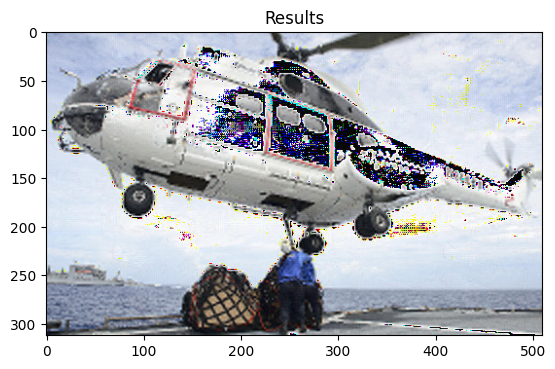

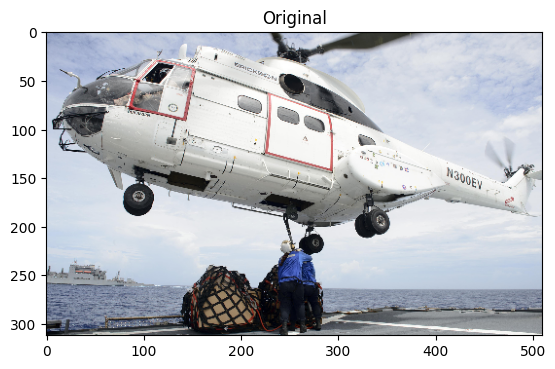

In [ ]:
#this print out results on a picture
PICTURE_NUM = 5 #there are 100 pictures, change to num between 0 - 99 to see other imgs
for i, (pic,label) in enumerate(train_loader2):
  if i == PICTURE_NUM:
    pic = pic.to(device)
    label = label.to(device)

    out = model(pic)
    loss = loss_function(out, label)
    pic = torch.squeeze(pic,0)
    out = torch.squeeze(out,0)
    label = torch.squeeze(label,0)

    out = torch.reshape(out,(SHAPE_OUT[1],SHAPE_OUT[2],SHAPE_OUT[0]))
    in1 = torch.reshape(pic,(SHAPE_IN[1],SHAPE_IN[2],SHAPE_IN[0]))
    ilabel = torch.reshape(label,(SHAPE_OUT[1],SHAPE_OUT[2],SHAPE_OUT[0]))

    outc = out.cpu()
    inc = in1.cpu()
    ilabel = ilabel.cpu()
    nout = outc.detach().numpy()
    ninc = inc.detach().numpy()
    nlabel = ilabel.detach().numpy()

    nout = nout.astype(np.uint8)
    ninc = ninc.astype(np.uint8)
    nlabel = nlabel.astype(np.uint8)


    newimg = cv2.resize(ninc, dsize = None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC) + nout
    newimg2 = cv2.resize(ninc, dsize = None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC) + nlabel

    newimg = newimg.astype(np.uint8)
    newimg2 = newimg2.astype(np.uint8)
    plt.imshow(cv2.cvtColor(newimg, cv2.COLOR_BGR2RGB) )
    plt.title('Results')
    plt.show()
    plt.imshow(cv2.cvtColor(newimg2, cv2.COLOR_BGR2RGB) )
    plt.title('Original')
    plt.show()
